# Library amd Module Imports
<b>Description: </b> 
    All the required packages, modules and libraries are imported here for this notebook.
___

In [1]:
import sys
import os
import gc
import math
import time
import pickle
import numpy as np
import random
import copy
import json
import warnings
import netCDF4 as nc
from typing import Callable, List, Optional
from pathlib import Path
from datetime import datetime as dt

# Progress Visualization
# from tqdm import tqdm
from tqdm.notebook import tqdm
# import matplotlib
# matplotlib.use('Agg')
import matplotlib.pyplot as plt
from torch.utils.tensorboard import SummaryWriter

# Neural Networks
import torch
import torch.nn.functional as F
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset, Subset
from torchvision.transforms.functional import gaussian_blur
# Parallel training
import torch.multiprocessing as mp
from torch.utils.data.distributed import DistributedSampler
from torch.nn.parallel import DistributedDataParallel as DDP
from torch.distributed import init_process_group, destroy_process_group

# Image Manipulation
import scipy
from scipy.ndimage import gaussian_filter
from PIL import Image
from torchvision.utils import save_image
from scipy.stats import kurtosis, skew
from scipy import ndimage, special, linalg

# import imageio.v3 as iio
# import torchvision
# import torchvision.transforms as transforms

# Evaluation Metrics

C:\Users\vasub\AppData\Roaming\Python\Python39\site-packages\networkx\utils\backends.py:135: RuntimeWarning: networkx backend defined more than once: nx-loopback
  backends.update(_get_backends("networkx.backends"))


# Utility Functions

In [2]:
# Helper functions
def compute_spectral_image(image, ifft=False, magnitude=False, normalize=False):
    """
    Computes the spectral image using the magnitude of the 2D Fourier Transform.
    
    Args:
        image (numpy array): A single CT scan patch (grayscale).
    
    Returns:
        spectral_image (numpy array): The spectral representation.
    """
    fft_shift = None
    if ifft:
        fft_shift = np.fft.ifftshift(image)  # Shift zero frequency to center
    else:
        fft_image = np.fft.fft2(image)  # Apply 2D Fourier Transform
        fft_shift = np.fft.fftshift(fft_image)  # Shift zero frequency to center
    
    if magnitude:
        magnitude_spectrum = np.abs(fft_shift)  # Get magnitude
        # Normalize the spectrum for consistency
        magnitude_spectrum = np.log1p(magnitude_spectrum)  # Log scaling
        
        if normalize:
            magnitude_spectrum = (magnitude_spectrum - np.min(magnitude_spectrum)) / (np.max(magnitude_spectrum) - np.min(magnitude_spectrum))  # Normalize [0,1]
            
        return fft_shift.astype(np.complex64), magnitude_spectrum
    else: 
        return fft_shift.astype(np.complex64)

bernoulli_mask_cache = dict()
poisson_mask_cache = dict()
def corrupt_data(img, spec, corruption_type="bspec", **kwargs):
    """
    Corrupts the image and spectral image with the given corruption_type.
    
    Args:
        img (numpy array): A single CT scan patch (grayscale).
        spectral_image (numpy array): The spectral representation.
    
    Returns:
        img (numpy array): CT scan patch after corruption (grayscale).
        spectral_image (numpy array): The corrupted spectral representation. 
        spectral_mask (numpy array): The corruption mask of spectral image.
    """ 
    # print(img.shape, spec.shape)
    
    if corruption_type == "bspec":
        # print("Bernoulli Process")
        p_at_edge = kwargs["corruption_params"]['p_edge']
        global bernoulli_mask_cache
        if bernoulli_mask_cache.get(p_at_edge) is None:
            half = [s//2 for s in spec.shape]
            r_dist = [np.arange(s, dtype=np.float32) - h for s, h in zip(spec.shape, half)]
            r_dist = [x ** 2 for x in r_dist]
            r_dist = (r_dist[0][:, np.newaxis] + r_dist[1][np.newaxis, :]) ** .5 # r_dist[0]: Horizontal Component, r_dist[1]: Vertical Component
            bernoulli_mask_probab = (p_at_edge ** (1.0/half[1])) ** r_dist
            bernoulli_mask_cache[p_at_edge] = bernoulli_mask_probab
            # print('Bernoulli probability at edge = %.5f' % bernoulli_mask_probab[half[0], 0])
            # print('Average Bernoulli probability = %.5f' % np.mean(bernoulli_mask_probab))
        mask = bernoulli_mask_cache[p_at_edge]
        keep = (np.random.uniform(0.0, 1.0, size=spec.shape)**2 < mask)
        keep = keep & keep[::-1, ::-1]
        mskd_spec = spec * keep
        spec_msk = keep.astype(np.float32)
        spec = compute_spectral_image(mskd_spec / (mask + ~keep + 1e-8), ifft=True)
        img = np.real(np.fft.ifft2(spec)).astype(np.float32)
        return img, mskd_spec, spec_msk
        
    elif corruption_type == "poisson":
        # print("Poisson Process")
        corruption_strength = kwargs["corruption_params"]['poisson_strength']
        mask = None
        global poisson_mask_cache
        poisson_noise = np.random.poisson(np.abs(img) * corruption_strength)/corruption_strength
        # poisson_noise = np.clip(poisson_noise, 0, 255)
        
        if kwargs["corruption_params"]['distribution'] == 'uniform':
            assert kwargs["corruption_params"]['mask_ratio'] is not None
            criterion = kwargs["corruption_params"]['mask_ratio']
            
        elif kwargs["corruption_params"]['distribution'] == 'gaussian':
            assert kwargs["corruption_params"]['sigma'] is not None
            criterion = gaussian_mask(img.shape, kwargs["corruption_params"]['sigma'])
        
        if poisson_mask_cache.get((kwargs["corruption_params"]['distribution'], criterion)) is None:
            mask = np.random.uniform(0, 1, size=img.shape) < criterion
            mask = mask.astype(np.float32)
            poisson_mask_cache[(kwargs["corruption_params"]['distribution'], criterion)] = mask
        else:
            mask = poisson_mask_cache[(kwargs["corruption_params"]['distribution'], criterion)].astype(np.float32)
            
        img = np.where(mask, poisson_noise, img)
        spec = compute_spectral_image(img)
        return img, spec, mask
        
    else:
        # Not a valid corruption/No corruption
        print("No Corruption")
        return img, spec, np.ones_like(img)
        
augment_translate_cache = dict()
def augment_data(img, spec, params):
    t = params.get('translate', 0)
    if t > 0:
        global augment_translate_cache
        trans = np.random.randint(-t, t + 1, size=(2,))
        key = (trans[0], trans[1])
        if key not in augment_translate_cache:
            x = np.zeros_like(img)
            x[trans[0], trans[1]] = 1.0
            augment_translate_cache[key] = compute_spectral_image(x)
        img = np.roll(img, trans, axis=(0, 1))
        spec = spec * augment_translate_cache[key]
    return img.astype(np.float32), spec


# Dataset Management

## Dataset Paths

In [3]:
isHQ = 1
fullDataset=True  # If False, provide the custom dir name. "TrainScans" - Placeholder

dataset_root_dir = Path("./Image Datasets") / ("HQ_Mphase" if isHQ else "LQ_Mphase")
ds_dir = Path("datasets")


dataset_scans_folder = dataset_root_dir / ("tomo_RMG_nc" if fullDataset else "TrainScans")
print(f"Original Dataset Root: [ {dataset_root_dir} ]")
print(f"Dataset .nc Scans: [ {dataset_scans_folder} ]")
print(f"Dataset .pth Files: [ {ds_dir} ]")

Original Dataset Root: [ Image Datasets\HQ_Mphase ]
Dataset .nc Scans: [ Image Datasets\HQ_Mphase\tomo_RMG_nc ]
Dataset .pth Files: [ datasets ]


## Dataset Processing

### Scan files to Images

<b>Description:</b> The following code block reads x-ray scans(.nc files) and generates grayscale images for each vertical resolution/slice(.png Images).
___

In [4]:
def nc_to_img(dataset_path, output_path):
    
    output_path.mkdir(parents=True, exist_ok=True)

    global_slice_idx = 0
    block_pths = dataset_path.glob("*.nc")

    # Set min and max thresholds for the range of important values. [Clamping values to rescale the spectrum]
    min_val = 7300 #np.iinfo(np.uint16).min # -24368
    max_val = 19300 #np.iinfo(np.uint16).max # -14468 
    diff = float(max_val - min_val)

    for block_pth in tqdm(sorted(block_pths), desc="Blocks", leave=True, position=0):
        scan_data = None
        
        with nc.Dataset(block_pth, 'r') as block:
            scan_data = block.variables['tomo'][:]
            
        # print(f"Scan Data Shape: {scan_data.shape}")
        n_slices, H, W = scan_data.shape
        
        for slice_idx in tqdm(range(n_slices), desc=f'Slices [Block: {block_pth.name}]', leave=False, position=1):
            # Extract the slice
            slice_data = scan_data[slice_idx, :, :]
    
            # Normalize all data values to the range [0, 255].
            slice_data = slice_data.astype('uint16')
            slice_data = slice_data.astype('float64')
            slice_data = np.clip(slice_data, min_val, max_val)
            slice_data = ((slice_data - min_val)/diff) * 255.0
            slice_data = slice_data.astype(np.uint8)  # Ensure the data is in uint8 format (0-255)
            
            img = Image.fromarray(slice_data)
            
            # Ensure Grayscale
            img = img.convert('L')

            # Rescale the image dims (Not required)
            # img = img.resize((1024, 1024), Image.LANCZOS)
            # img = img.resize((512, 512), Image.LANCZOS)
            # img = img.resize((256, 256), Image.LANCZOS)

            # Generate the image name and save it
            save_path = output_path / f"{global_slice_idx :06d}.png"
            img.save(save_path)
            
            global_slice_idx += 1
    
            # print(f"Saved {slice_filename} from {block_filename}")
        print(f"Saved All Slices from {block_pth.name}")
            
    print("All slices have been saved successfully.")

In [5]:
# output_pth = dataset_root_dir / "Full_Dataset_Images"
# print(output_pth)

# nc_to_img(dataset_scans_folder, output_pth)

### Images to Patches

<b>Description:</b> This code block creates patches from a larger image in sequential order.
___

In [6]:
def extract_patches(img, patch_size=255, overlap=0.5, threshold=0):
    step = int(patch_size * (1 - overlap))
    patches = []
    h, w = img.shape[:2]
    
    for i in range(0, h - patch_size + 1, step):
        for j in range(0, w - patch_size + 1, step):
            patch = img[i:i + patch_size, j:j + patch_size]
            variance = np.var(patch)
            if variance >= threshold:
                patches.append(patch)

        if (w - patch_size) % step != 0:
            j = w - patch_size
            patch = img[i:i + patch_size, j:j + patch_size]
            variance = np.var(patch)
            if variance >= threshold:
                patches.append(patch)
    
    # Add bottom row patches (bottom edge)
    if (h - patch_size) % step != 0:
        i = h - patch_size
        for j in range(0, w - patch_size + 1, step):
            patch = img[i:i + patch_size, j:j + patch_size]
            variance = np.var(patch)
            if variance >= threshold:
                patches.append(patch)

        # Also add the bottom-right corner patch
        if (w - patch_size) % step != 0:
            j = w - patch_size
            patch = img[i:i + patch_size, j:j + patch_size]
            variance = np.var(patch)
            if variance >= threshold:
                patches.append(patch)
       
    return patches

def load_images_for_patching(src_path:Path, dst_path:Path, patch_size=255, overlap=0.5, threshold=0):
    
    dst_path.mkdir(parents=True, exist_ok=True)
    imgs_pths = src_path.glob("*.png")
    
    global_patch_idx = 0
    img_idx = 0

    for img_pth in tqdm(sorted(imgs_pths), desc="Images", leave=True, position=0):
        img = None
        try:
            img = Image.open(img_pth).convert('L')
        except FileNotFoundError:
            print(f"Error: Image file not found at {img_pth}")
        except Exception as e:
            print(f"An error occurred: {e}")

        patches = extract_patches(np.array(img), patch_size=patch_size, overlap=overlap, threshold=threshold)
        
        # Save Patches
        for patch in tqdm(patches, desc="Patches", leave=False, position=1):
            save_path = dst_path / f"{global_patch_idx :08d}.png"
            p = Image.fromarray(patch)
            p.save(save_path)
            global_patch_idx += 1

        img_idx += 1

    print(f"Total Patches: {global_patch_idx}")
    print(f"All patches saved to - {dst_path}")

In [7]:
patch_size = 255
overlap = 0.5
threshold = 0

src_image_folder = "evalImgs"
dst_patch_folder = "eval" 
src_pth = dataset_root_dir / src_image_folder
dst_pth = dataset_root_dir / (dst_patch_folder + f"_patches_{str(patch_size)}")
print(f"Source: [ {src_pth} ]")
print(f"Destination: [ {dst_pth} ]")

# load_images_for_patching(src_path=src_pth, dst_path=dst_pth, patch_size=patch_size, overlap=overlap, threshold=threshold)

Source: [ Image Datasets\HQ_Mphase\evalImgs ]
Destination: [ Image Datasets\HQ_Mphase\eval_patches_255 ]


## Dataset Class

In [8]:
# Dataset with just img and spec
class CTScans(Dataset):
    def __init__(self, images, spectrals):    
        self.images = images.astype(np.float32)
        self.spectrals = spectrals.astype(np.complex64)
        
    def __len__(self):
        return self.images.shape[0]

    def __getitem__(self, idx):
        return self.images[idx], self.spectrals[idx]
        
def create_dataset(images_path=Path("")):
    file_paths = sorted([f for f in images_path.iterdir() if f.suffix == ".png"])
    if not file_paths:
        raise ValueError(f"No PNG files found at - {str(images_path)}")

    print(f"Source Images Path - {images_path}")
    temp_img = np.array(Image.open(file_paths[0]).convert("L"))
    H, W = temp_img.shape
    L = len(file_paths)
    
    imgs = np.zeros((L, H, W), dtype=np.float32)
    specs = np.zeros((L, H, W), dtype=np.complex64)
    
    for idx, file_path in tqdm(enumerate(file_paths), total=len(file_paths), desc="Images"):
        imgs[idx] = (np.array(Image.open(file_path).convert("L"), dtype=np.float32) / 255.0) - 0.5
        specs[idx] = compute_spectral_image(imgs[idx])

    return CTScans(imgs, specs)

## Create Dataset

In [9]:
# Creating datasets
patches = True
dataset_create = False
save_dataset = False

train_dataset = None
valid_dataset = None
eval_dataset = None

if dataset_create:
    if patches:
        # Create Patch Datasets
        train_dataset = create_dataset(images_path=dataset_root_dir / "train_patches_255")
        valid_dataset = create_dataset(images_path=dataset_root_dir / "valid_patches_255")
        eval_dataset = create_dataset(images_path=dataset_root_dir / "eval_patches_255")
    
        if save_dataset:
            torch.save(train_dataset, ds_dir / "LQ_train_dataset_20.pth", pickle_protocol=4)
            torch.save(valid_dataset, ds_dir / "LQ_valid_dataset_5.pth", pickle_protocol=4)
            torch.save(eval_dataset, ds_dir / "LQ_eval_dataset_10.pth", pickle_protocol=4)
    else:
        # Create Full Image Datasets
        train_dataset = create_dataset(images_path=dataset_root_dir / "trainImgs")
        valid_dataset = create_dataset(images_path=dataset_root_dir / "validImgs")
        eval_dataset = create_dataset(images_path=dataset_root_dir / "evalImgs")
        if save_dataset:
            torch.save(train_dataset, ds_dir / "HQ_train_full_img.pth", pickle_protocol=4)
            torch.save(valid_dataset, ds_dir / "HQ_valid_full_img.pth", pickle_protocol=4)
            torch.save(eval_dataset, ds_dir / "HQ_eval_full_img.pth", pickle_protocol=4)
        
    

## Load Dataset

In [10]:
patches = True
if train_dataset is None or valid_dataset is None or eval_dataset is None: 
    if patches:
        # Patch Dataset
        train_dataset = torch.load(ds_dir / "HQ_train_dataset_20.pth", weights_only=False)
        valid_dataset = torch.load(ds_dir / "HQ_valid_dataset_5.pth", weights_only=False)
        eval_dataset = torch.load(ds_dir / "LQ_eval_dataset_10.pth", weights_only=False)
    else:    
        # Full sized Image Datasets
        train_dataset = torch.load(ds_dir / "HQ_eval_full_img.pth", weights_only=False)
        valid_dataset = torch.load(ds_dir / "HQ_valid_full_img.pth", weights_only=False)
        eval_dataset = torch.load(ds_dir / "HQ_eval_full_img.pth", weights_only=False)
        # valid_dataset = train_dataset # For testing only

## Visualize Data Sample

In [11]:
# Needs an Update
#                                                            Visualize a Sample from the Dataset
#
def visualize_dataset(train_dataset, valid_dataset):
    tr_inp, tr_targ, tr_sp, tr_msk, tr_orig = next(iter(train_dataset))
    va_inp, va_targ, va_sp, va_msk, va_orig = next(iter(valid_dataset))
    
    # print(tr_inp.dtype, tr_targ.dtype, tr_sp.dtype, tr_msk.dtype, tr_orig.dtype)
    # print(va_inp.dtype, va_targ.dtype, va_sp.dtype, va_msk.dtype, va_orig.dtype)
    
    fig, axes = plt.subplots(2,5, figsize=(25,10))
    
    # Training Dataset
    axes[0][0].imshow(tr_orig, cmap='gray', vmin=0, vmax=1)
    axes[0][0].set_title("Original")
    
    axes[0][1].imshow(tr_inp, cmap='gray', vmin=0, vmax=1)
    axes[0][1].set_title("Input")
    
    axes[0][2].imshow(tr_targ, cmap='gray', vmin=0, vmax=1)
    axes[0][2].set_title("Target")
    
    axes[0][3].imshow(np.log1p(np.abs(tr_sp)), cmap='inferno')
    axes[0][3].set_title("Input's Spectral")
    
    axes[0][4].imshow(tr_msk, cmap='gray')
    axes[0][4].set_title("Spectral Mask")
    
    # Validation Dataset
    axes[1][0].imshow(va_orig, cmap='gray', vmin=0, vmax=1)
    axes[1][0].set_title("Original")
    
    axes[1][1].imshow(va_inp, cmap='gray', vmin=0, vmax=1)
    axes[1][1].set_title("Input")
    
    axes[1][2].imshow(va_targ, cmap='gray', vmin=0, vmax=1)
    axes[1][2].set_title("Target")
    
    axes[1][3].imshow(np.log1p(np.abs(va_sp)), cmap='inferno')
    axes[1][3].set_title("Inputs's Spectral")
    
    axes[1][4].imshow(va_msk, cmap='gray')
    axes[1][4].set_title("Spectral Mask")
    
    plt.show()

assert train_dataset is not None and valid_dataset is not None, "Training Dataset and Validation Dataset should not be None"
# visualize_dataset(train_dataset, valid_dataset)

# NIQE Metric

In [12]:
src_dir = Path("./Datasets/HQ_Mphase/Full_Dataset_Images")
dst_dir = Path("PyTorchDatasets")
# This version actually worked.
class NIQE:
    def __init__(self, src_pth:Path=Path(""), dst_pth:Path=Path(""), sigma:float=7/6):
        self.mean_vector=None
        self.covariance_matrix=None
        self.sigma=sigma
        self.src_pth=src_pth
        self.dst_pth=dst_pth
        
    def _compute_mscn_coefficients(self, image: np.ndarray) -> np.ndarray:
        # print("Compute MSCN")
        image = image.astype(np.float32) / 255.0
        mu = gaussian_filter(image, sigma=self.sigma)
        # print("gaussian filter 1")
        mu_sq = mu * mu
        sigma = np.sqrt(np.abs(gaussian_filter(image * image, sigma=self.sigma) - mu_sq))
        # print("Gaussian filter 2")
        mscn = (image - mu) / (sigma + 1e-8)
        return mscn

    def _extract_features(self, image: np.ndarray) -> np.ndarray:
        # print("Extract features")
        mscn = self._compute_mscn_coefficients(image)
        mscn_flat = mscn.flatten()
        features = [
            np.mean(mscn_flat),
            np.var(mscn_flat),
            skew(mscn_flat),
            kurtosis(mscn_flat)
        ]
        # Compute features on shifted versions
        shifts = [(0, 1), (1, 0), (1, 1), (1, -1)]
        for dx, dy in shifts:
            shifted = np.roll(mscn, shift=dx, axis=0)
            shifted = np.roll(shifted, shift=dy, axis=1)
            product = mscn * shifted
            product_flat = product.flatten()
            features += [
                np.mean(product_flat),
                np.var(product_flat),
                skew(product_flat),
                kurtosis(product_flat)
            ]
        return np.array(features, dtype=np.float32)

    def train(self, src_dir: Path=None, dst_dir: Path=None, file_name:str="NIQE"):
        """
        src_dir: Path to the directory containing training images (8-bit grayscale PNGs).
        The function will load all images, convert them to tensors, and use them for training.
        """
        src_dir = src_dir or self.src_pth
        dst_dir = dst_dir or self.dst_pth
        
        images = []
        features = []
        for image_path in tqdm(list(src_dir.glob('*.png')), desc=f'Loading images from {src_dir}'):
            images.append()
            image = np.array(Image.open(image_path).convert('L')).astype(np.uint8)
            feats = self._extract_features(image)
            if feats.size > 0:
                features.append(feats)
        
        if not features:
            raise ValueError("No valid features extracted from images.")
        
        features = np.vstack(features)
        self.mean_vector = np.mean(features, axis=0)
        self.covariance_matrix = np.cov(features, rowvar=False)

        # self.save(path=dst_dir, file_name=file_name)
    
    def save(self, path:Path=None, file_name:str="NIQE"):
        if self.mean_vector is None or self.covariance_matrix is None:
            raise ValueError("NIQE model not trained yet.")
            
        if path is None:
            path = self.dst_pth
            warnings.warn(f"Empty Path Warning! Saving to current active directory: {path}")
        print(f"Saving model to: [ {path} ] as - [ {(file_name + '_mu.npz')} ] and [ {(file_name + '_cov.npz')} ]")
        
        temp_path = path / (file_name + "_mu")
        np.savez(temp_path.with_suffix(".npz"), mu=self.mean_vector.astype(np.float32))
        
        temp_path = path / (file_name + "_cov")
        np.savez(temp_path.with_suffix(".npz"), cov=self.covariance_matrix.astype(np.float32))
        
        print(f"mu shape: {self.mean_vector.shape}, dtype: {self.mean_vector.dtype}")
        print(f"cov shape: {self.covariance_matrix.shape}, dtype: {self.covariance_matrix.dtype}")
    
    def load(self, path: Path=None, file_name:str="NIQE"):
        if path is None:
            path = self.dst_pth
            warnings.warn(f"Empty Path Warning! Loading from current active directory: {path}")
        print("Loading params for NIQE")
        
        temp_path = path / (file_name + "_mu")
        self.mean_vector = np.load(temp_path.with_suffix(".npz"))['mu']
        
        temp_path = path / (file_name + "_cov")
        self.covariance_matrix = np.load(temp_path.with_suffix(".npz"))['cov']
        
        print(self.mean_vector.shape)
        print(self.covariance_matrix.shape)

    def score(self, image: np.ndarray) -> float:
        """
        image_tensor: torch.Tensor of shape [1, H, W] or [H, W], values in [-0.5, 0.5] (float32)
        """
        if self.mean_vector is None or self.covariance_matrix is None:
            raise ValueError("NIQE model parameters not loaded or trained.")
        print("Start Scoring")
        # print(image.shape, type(image), image.dtype, len(image))
        if image.ndim == 3:
            image = image[0]  # shape [H, W]
        elif image.ndim != 2:
            raise ValueError(f"Expected ndarray with shape [1, H, W] or [H, W], got {image.shape}")

        image_np = np.clip((image + 0.5) * 255, 0, 255).astype(np.uint8)
        feat = self._extract_features(image_np)
        # print(feat.shape, self.mean_vector)
        delta = feat - self.mean_vector
        try:
            inv_cov = np.linalg.inv(self.covariance_matrix)
        except RuntimeError:
            inv_cov = np.linalg.pinv(self.covariance_matrix)

        score = np.sqrt(np.dot(np.dot(delta, inv_cov), delta))
        return float(score)

In [13]:
src_dir = Path("./Datasets/HQ_Mphase/Full_Dataset_Images")
dst_dir = Path("PyTorchDatasets")

class NIQEN:
    def __init__(self, src_pth:Path=Path(""), dst_pth:Path=Path(""), sigma:float=7/6, patch_size=96):
        self.mean_vector=None
        self.covariance_matrix=None
        self.sigma=sigma
        self.patch_size = patch_size
        self.src_pth=src_pth
        self.dst_pth=dst_pth
        
    def __call__(self, image) -> float:
        return self.score(image)
    
    def save(self, path:Path=None, file_name:str="NIQE_model"):
        if self.mean_vector is None or self.covariance_matrix is None:
            raise ValueError("NIQE model not trained yet.")
            
        if path is None:
            path = self.dst_pth
            warnings.warn(f"Empty Path Warning! Saving to current active directory: {path}")
        print(f"Saving model to: [ {path} ] as - [ {(file_name + '_mu.npz')} ] and [ {(file_name + '_cov.npz')} ]")
        
        temp_path = path / (file_name + "_mu")
        np.savez(temp_path.with_suffix(".npz"), mu=self.mean_vector.astype(np.float32), patch_size=self.patch_size)
        
        temp_path = path / (file_name + "_cov")
        np.savez(temp_path.with_suffix(".npz"), cov=self.covariance_matrix.astype(np.float32))
        
        # print(f"mu shape: {self.mean_vector.shape}, dtype: {self.mean_vector.dtype}")
        # print(f"cov shape: {self.covariance_matrix.shape}, dtype: {self.covariance_matrix.dtype}")
        # print(f"Patch Size: {self.patch_size}")
        print(f"Covariance Matrix({self.covariance_matrix.shape}), Mean Vector({self.mean_vector.shape}) and Patch Size({self.patch_size}) saved successfuly!")

    def load(self, path: Path=None, file_name:str="NIQE_model"):
        if path is None:
            path = self.dst_pth
            warnings.warn(f"Empty Path Warning! Loading from current active directory: {path}")
        print("Loading params for NIQE")
        
        temp_path = path / (file_name + "_mu")
        data = np.load(temp_path.with_suffix(".npz"))
        self.mean_vector = data['mu']
        self.patch_size = data['patch_size']
        
        temp_path = path / (file_name + "_cov")
        self.covariance_matrix = np.load(temp_path.with_suffix(".npz"))['cov']
        
        # print(self.mean_vector.shape)
        # print(self.covariance_matrix.shape)
        # print(self.patch_size)
        print(f"Covariance Matrix({self.covariance_matrix.shape}), Mean Vector({self.mean_vector.shape}) and Patch Size({self.patch_size}) loaded successfuly!")
    
    def _aggd_features(self, imdata):
        """ Compute AGGD (Asymmetric Generalized Gaussian Distribution) features """
        imdata = imdata.flatten()
        imdata2 = imdata ** 2
        left_data = imdata2[imdata < 0]
        right_data = imdata2[imdata >= 0]
        lsq = np.sqrt(np.mean(left_data)) if len(left_data) > 0 else 0
        rsq = np.sqrt(np.mean(right_data)) if len(right_data) > 0 else 0
        gamma_hat = lsq / rsq if rsq != 0 else np.inf

        denominator = np.mean(imdata2)
        if denominator == 0:
            print("Warning: Zero variance in patch. Skipping or using default values.")
            return 0, 0, 0, 0, 0, 0
        
        r_hat = (np.mean(np.abs(imdata)) ** 2) / denominator
        rhat_norm = r_hat * (((gamma_hat ** 3 + 1) * (gamma_hat + 1)) / ((gamma_hat ** 2 + 1) ** 2))

        gamma_range = np.arange(0.2, 10, 0.001)
        prec_gammas = (special.gamma(2.0 / gamma_range) ** 2) / (special.gamma(1.0 / gamma_range) * special.gamma(3.0 / gamma_range))
        pos = np.argmin((prec_gammas - rhat_norm) ** 2)
        alpha = gamma_range[pos]

        gam1 = special.gamma(1.0 / alpha)
        gam2 = special.gamma(2.0 / alpha)
        gam3 = special.gamma(3.0 / alpha)
        aggdratio = np.sqrt(gam1) / np.sqrt(gam3)
        bl = aggdratio * lsq
        br = aggdratio * rsq
        N = (br - bl) * (gam2 / gam1)
        return alpha, N, bl, br, lsq, rsq

    def _paired_product(self, im):
        """ Compute pairwise products of MSCN transformed image """
        H = np.roll(im, -1, axis=1) * im
        V = np.roll(im, -1, axis=0) * im
        D1 = np.roll(np.roll(im, -1, axis=0), -1, axis=1) * im
        D2 = np.roll(np.roll(im, -1, axis=0), 1, axis=1) * im
        return H, V, D1, D2
    
    def _extract_patch_features(self, patch):
        """ Extract features from image patch """
        alpha_m, N, bl, br, lsq, rsq = self._aggd_features(patch.copy())
        pps = self._paired_product(patch)
        results = [alpha_m, (bl + br) / 2.0]
        for pp in pps:
            a, N, bl, br, _, _ = self._aggd_features(pp)
            results.extend([a, N, bl, br])
        return np.array(results)
    
    def _extract_patches(self, img, patch_size):
        """ Extract patches from the MSCN-transformed image """
        h, w = img.shape
        patches = []
        for j in range(0, h - patch_size + 1, patch_size):
            for i in range(0, w - patch_size + 1, patch_size):
                patch = img[j:j + patch_size, i:i + patch_size]
                if patch.shape == (patch_size, patch_size):
                    patches.append(self._extract_patch_features(patch))
        if len(patches) == 0:
            return np.empty((0, 18), dtype=np.float32)
        return np.array(patches)

    def _extract_features(self, img):
        """ Extract features from an entire image """
        mscn1, _, _ = self._compute_mscn_transform(img)
        mscn2, _, _ = self._compute_mscn_transform(ndimage.zoom(img, 0.5, order=3))
        
        f1 = self._extract_patches(mscn1, self.patch_size)
        f2 = self._extract_patches(mscn2, self.patch_size // 2)
        
        if f1.size == 0 or f2.size == 0:
            return np.empty((0, 36), dtype=np.float32)
        
        return np.hstack((f1, f2))
    
    def _gen_gauss_window(self, lw, sigma):
        """ Generate a Gaussian window for MSCN filtering """
        sd = float(sigma)
        lw = int(lw)
        weights = [0.0] * (2 * lw + 1)
        weights[lw] = 1.0
        s = 1.0
        sd *= sd
        for ii in range(1, lw + 1):
            tmp = np.exp(-0.5 * ii * ii / sd)
            weights[lw + ii] = tmp
            weights[lw - ii] = tmp
            s += 2.0 * tmp
        for ii in range(2 * lw + 1):
            weights[ii] /= s
        return weights

    def _compute_mscn_transform(self, image, C=1, avg_window=None):
        """ Compute MSCN (Mean Subtracted Contrast Normalized) transformation """
        if avg_window is None:
            avg_window = self._gen_gauss_window(3, self.sigma)
        
        h, w = image.shape
        mu = np.zeros((h, w), dtype=np.float32)
        var = np.zeros((h, w), dtype=np.float32)
        
        image = image.astype(np.float32)
        ndimage.correlate1d(image, avg_window, 0, mu, mode='reflect')
        ndimage.correlate1d(mu, avg_window, 1, mu, mode='reflect')
        ndimage.correlate1d(image**2, avg_window, 0, var, mode='reflect')
        ndimage.correlate1d(var, avg_window, 1, var, mode='reflect')
        var = np.sqrt(np.abs(var - mu**2))
        
        return (image - mu) / (var + C), var, mu
    
    def train(self, src_dir: Path=None, dst_dir: Path=None, file_name:str="NIQE_model"):
        """
        src_dir: Path to the directory containing training images (8-bit grayscale PNGs).
        The function will load all images, convert them to tensors, and use them for training.
        """
        src_dir = src_dir or self.src_pth
        dst_dir = dst_dir or self.dst_pth

        features = []
        for image_path in tqdm(list(src_dir.glob('*.png')), desc=f'Loading and Extracting Features for Images '):
            img = np.array(Image.open(image_path).convert('L')).astype(np.uint8)
            feats = self._extract_features(img)
            if feats.size > 0:
                features.append(feats)
            
        if not features:
            raise ValueError("No valid features extracted from images.")
        
        features = np.vstack(features)
        self.mean_vector = np.mean(features, axis=0)
        self.covariance_matrix = np.cov(features, rowvar=False)

        self.save(path=dst_dir, file_name=file_name)
    
    def score(self, img):
        """ Evaluate the NIQE score for a given image """
        if self.mean_vector is None or self.covariance_matrix is None:
            raise ValueError("NIQE model parameters not loaded or trained.")
            
        print("Start Scoring")
        if img.ndim == 3:
            img = img[0]  # shape [H, W]
        elif img.ndim != 2:
            raise ValueError(f"Expected ndarray with shape [1, H, W] or [H, W], got {img.shape}")
        
        img = np.clip((img + 0.5) * 255, 0, 255).astype(np.uint8)
        feats = self._extract_features(img)
        if feats.size == 0:
            raise ValueError("Image too small for feature extraction with given patch size.")
        
        sample_mu = np.mean(feats, axis=0)
        sample_cov = np.cov(feats, rowvar=False)
        delta = sample_mu - self.mean_vector
        covmat = (self.covariance_matrix + sample_cov) / 2.0
        pinvmat = linalg.pinv(covmat)

        score = np.sqrt(np.dot(np.dot(delta, pinvmat), delta))
        return float(score)

In [14]:
src_dir = Path("./Image Datasets/HQ_Mphase/Images")
dst_dir = Path("datasets")

class NIQEG:
    def __init__(self, src_pth: Path = Path(""), dst_pth: Path = Path(""), sigma: float = 7 / 6, patch_size=96, device=None):
        self.mean_vector = None
        self.covariance_matrix = None
        self.sigma = sigma
        self.patch_size = patch_size
        self.src_pth = src_pth
        self.dst_pth = dst_pth
        self.device = device or (torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu'))

    def __call__(self, image) -> float:
        return self.score(image)

    def save(self, path: Path = None, file_name: str = "NIQE"):
        if self.mean_vector is None or self.covariance_matrix is None:
            raise ValueError("NIQE model not trained yet.")

        if path is None:
            path = self.dst_pth
            warnings.warn(f"Empty Path Warning! Saving to current active directory: {path}")

        temp_path = path / (file_name + "_mu")
        np.savez(temp_path.with_suffix(".npz"), mu=self.mean_vector.astype(np.float32), patch_size=self.patch_size)

        temp_path = path / (file_name + "_cov")
        np.savez(temp_path.with_suffix(".npz"), cov=self.covariance_matrix.astype(np.float32))

        print(f"Covariance Matrix({self.covariance_matrix.shape}), Mean Vector({self.mean_vector.shape}) and Patch Size({self.patch_size}) saved successfully!")

    def load(self, path: Path = None, file_name: str = "NIQE"):
        if path is None:
            path = self.dst_pth
            warnings.warn(f"Empty Path Warning! Loading from current active directory: {path}")
        print("Loading params for NIQE")

        temp_path = path / (file_name + "_mu")
        data = np.load(temp_path.with_suffix(".npz"))
        self.mean_vector = data['mu']
        self.patch_size = data['patch_size']

        temp_path = path / (file_name + "_cov")
        self.covariance_matrix = np.load(temp_path.with_suffix(".npz"))['cov']

        print(f"Covariance Matrix({self.covariance_matrix.shape}), Mean Vector({self.mean_vector.shape}) and Patch Size({self.patch_size}) loaded successfully!")

    def _gen_gauss_kernel(self, kernel_size=7):
        coords = torch.arange(kernel_size, dtype=torch.float32) - kernel_size // 2
        g = torch.exp(-(coords ** 2) / (2 * self.sigma ** 2))
        g /= g.sum()
        kernel = torch.outer(g, g)
        return kernel.unsqueeze(0).unsqueeze(0)

    def _compute_mscn(self, image: torch.Tensor):
        kernel = self._gen_gauss_kernel().to(image.device)
        padding = kernel.shape[-1] // 2
        mu = F.conv2d(image, kernel, padding=padding)
        mu_sq = mu ** 2
        sigma = torch.sqrt(F.conv2d(image ** 2, kernel, padding=padding) - mu_sq + 1e-8)
        mscn = (image - mu) / (sigma + 1.0)
        return mscn

    def _aggd_features(self, imdata: torch.Tensor):
        imdata = imdata.flatten()
        if imdata.dim() > 1:
            imdata = imdata.squeeze(0)  # Only squeeze if necessary
        
        imdata2 = imdata ** 2
        left = imdata2[imdata < 0]
        right = imdata2[imdata >= 0]
        lsq = torch.sqrt(left.mean()) if left.numel() > 0 else torch.tensor(0.0, device=imdata.device)
        rsq = torch.sqrt(right.mean()) if right.numel() > 0 else torch.tensor(0.0, device=imdata.device)
        gamma_hat = lsq / rsq if rsq != 0 else torch.tensor(float('inf'), device=imdata.device)
        r_hat = (imdata.abs().mean() ** 2) / imdata2.mean()

        gamma_range = torch.arange(0.2, 10, 0.001, device=imdata.device)
        prec_gammas = (special.gamma(2.0 / gamma_range.cpu()) ** 2) / (
            special.gamma(1.0 / gamma_range.cpu()) * special.gamma(3.0 / gamma_range.cpu()))
        rhat_norm = r_hat * (((gamma_hat ** 3 + 1) * (gamma_hat + 1)) / ((gamma_hat ** 2 + 1) ** 2))
        pos = torch.argmin((torch.tensor(prec_gammas, device=imdata.device) - rhat_norm) ** 2)
        alpha = gamma_range[pos]

        gam1 = special.gamma(1.0 / alpha.item())
        gam2 = special.gamma(2.0 / alpha.item())
        gam3 = special.gamma(3.0 / alpha.item())
        aggdratio = np.sqrt(gam1) / np.sqrt(gam3)
        bl = aggdratio * lsq
        br = aggdratio * rsq
        N = (br - bl) * (gam2 / gam1)
        return torch.tensor([alpha, (bl + br) / 2.0], device=self.device) 
    
    def _aggd_pair_features(self, img):
        if img.dim() == 2:
            img = img.unsqueeze(0).unsqueeze(0)
        elif img.dim() == 3:
            img = img.unsqueeze(0)
        H = img * torch.roll(img, shifts=-1, dims=3)
        V = img * torch.roll(img, shifts=-1, dims=2)
        D1 = img * torch.roll(torch.roll(img, shifts=-1, dims=2), shifts=-1, dims=3)
        D2 = img * torch.roll(torch.roll(img, shifts=-1, dims=2), shifts=1, dims=3)
        features = []
        if img.dim() > 1:
            img = img.squeeze()  # Only squeeze if necessary
        for paired in [H, V, D1, D2]:
            features.extend(self._aggd_features(paired.squeeze(0).squeeze(0)))
        return torch.tensor(features, device=self.device)
    
    def _extract_features(self, imgs: torch.Tensor):
        if imgs.dim() == 3:
            imgs = imgs.unsqueeze(1)  # [B, 1, H, W] for grayscale, no C dimension
        imgs = imgs.to(self.device)
        mscn1 = self._compute_mscn(imgs)
        mscn2 = self._compute_mscn(F.interpolate(imgs, scale_factor=0.5, mode='bilinear', align_corners=False))

        features = []
        for mscn in tqdm([mscn1, mscn2], desc="Calculating MSCN ", position=1, leave=False):  # each: [B, 1, H, W]
            B, _, H, W = mscn.shape
            patches = []
            for i in range(0, H - self.patch_size + 1, self.patch_size):
                for j in range(0, W - self.patch_size + 1, self.patch_size):
                    patch = mscn[:, :, i:i+self.patch_size, j:j+self.patch_size]  # [B, 1, ps, ps]
                    if patch.shape[2:] == (self.patch_size, self.patch_size):
                        patches.append(patch)

            if patches:
                all_patches = torch.cat(patches, dim=0)  # [B * P, 1, ps, ps]
                # feats = [self._aggd_features(patch.squeeze(0).squeeze(0)) for patch in all_patches]
                feats = [torch.cat([self._aggd_features(patch.squeeze(0).squeeze(0)), self._aggd_pair_features(patch)]) for patch in tqdm(all_patches, position=2, leave=False)]
                features.extend(feats)

        if not features:
            return torch.empty((0, 36), dtype=torch.float32, device=self.device)
        return torch.stack(features)
    
    def train(self, src_dir: Path = None, dst_dir: Path = None, file_name: str = "NIQE", batch_size: int = 20):
        src_dir = src_dir or self.src_pth
        dst_dir = dst_dir or self.dst_pth
    
        # Initialize accumulators for features and number of samples
        accumulated_features = []
        num_samples = 0
    
        # Load images in mini-batches
        image_paths = list(src_dir.glob("*.png"))
        num_batches = len(image_paths) // batch_size + (1 if len(image_paths) % batch_size != 0 else 0)
        
        for batch_idx in tqdm(range(num_batches), desc=f"Processing images in batches from {src_dir}", position=0, leave=True):
            # Get the paths for the current batch of images
            batch_paths = image_paths[batch_idx * batch_size: (batch_idx + 1) * batch_size]
    
            # Load images for the current batch
            image_tensors = []
            for image_path in tqdm(batch_paths, desc=f"Images in batch {batch_idx}", position=1, leave=False):
                img = np.array(Image.open(image_path).convert("L"), dtype=np.uint8)
                img = torch.from_numpy(img).to(torch.float32)
                image_tensors.append(img)
    
            # Stack the images into a batch tensor [B, H, W]
            batch = torch.stack(image_tensors).to(self.device)
    
            # Extract features for the current batch
            feats = self._extract_features(batch)
            if feats.size(0) > 0:
                accumulated_features.append(feats.cpu())
                num_samples += feats.size(0)
    
        if num_samples == 0:
            raise ValueError("No valid features extracted from training images.")
    
        # Concatenate all extracted features into a single tensor
        all_features = torch.cat(accumulated_features, dim=0).numpy()
    
        # Compute the mean vector and covariance matrix
        self.mean_vector = all_features.mean(axis=0)
        self.covariance_matrix = np.cov(all_features, rowvar=False)
    
        # Save the model
        self.save(path=dst_dir, file_name=file_name)
    
    def score(self, img: np.ndarray):
        if self.mean_vector is None or self.covariance_matrix is None:
            raise ValueError("NIQE model parameters not loaded or trained.")

        print("Start Scoring")
        if img.ndim == 3:
            img = img[0]
        elif img.ndim != 2:
            raise ValueError(f"Expected ndarray with shape [1, H, W] or [H, W], got {img.shape}")

        img = np.clip((img + 0.5) * 255, 0, 255).astype(np.uint8)
        img = torch.tensor(img, dtype=torch.float32, device=self.device)
        img = img.unsqueeze(0).unsqueeze(0)
        feats = self._extract_features(img)
        if feats.size(0) == 0:
            raise ValueError("Image too small for feature extraction with given patch size.")

        feats = feats.cpu().numpy()
        sample_mu = np.mean(feats, axis=0)
        sample_cov = np.cov(feats, rowvar=False)
        delta = sample_mu - self.mean_vector
        covmat = (self.covariance_matrix + sample_cov) / 2.0
        pinvmat = linalg.pinv(covmat)
        score = np.sqrt(np.dot(np.dot(delta, pinvmat), delta))
        return float(score)


In [15]:
# Train the NIQE model

# niqe_model = NIQEG(src_pth=src_dir, dst_pth=dst_dir)
# niqe_model.load(file_name="NIQEG")
# niqe_model.train(file_name="NIQEG")

In [16]:
# del niqe_model
# gc.collect() # GC collects the deleted model and clears the memory.
# torch.cuda.empty_cache() # Removes any cache data related to the removed model from the GPU.

In [17]:
# image_path = list((dataset_root_dir / "evalImgs").glob('*.png'))[0]
# im = Image.open(image_path).convert('L')
# image = np.array(im, dtype=np.float32)/255.0 - 0.5
# print(image.min(), image.max())

# plt.figure(figsize=(5,5))
# plt.imshow(im, cmap='gray')

In [18]:
# print(image.shape)
# for idx, img_path in enumerate(list((dataset_root_dir / "evalImgs").glob('*.png'))):
    # im = Image.open(image_path).convert('L')
    # image = np.array(im, dtype=np.float32)/255.0 - 0.5
    # score = niqe_model.score(image)
    # print(f"Image {idx} -> {score}")

In [19]:
# PATH = Path("./Results_bernoulli_test_5/Evaluation Tests_0/output001.png")
# I = np.array(Image.open(PATH).convert('L'), dtype=np.uint8)
# plt.figure(figsize=(20,20))
# plt.imshow(I, cmap='gray')
# I = np.array(I, dtype=np.float32)/255.0 - 0.5
# niqe_model.score(I)

In [20]:
import numpy as np
from scipy import ndimage, special, linalg

class NIQE2:
    def __init__(self, patch_size=96):
        self.patch_size = patch_size
        self.mu = None
        self.cov = None

    def save(self, path):
        np.savez(path, mu=self.mu, cov=self.cov, patch_size=self.patch_size)

    def load(self, path):
        data = np.load(path)
        self.mu = data['mu']
        self.cov = data['cov']
        self.patch_size = int(data['patch_size'])

    def _gen_gauss_window(self, lw, sigma):
        sd = float(sigma)
        lw = int(lw)
        weights = [0.0] * (2 * lw + 1)
        weights[lw] = 1.0
        s = 1.0
        sd *= sd
        for ii in range(1, lw + 1):
            tmp = np.exp(-0.5 * ii * ii / sd)
            weights[lw + ii] = tmp
            weights[lw - ii] = tmp
            s += 2.0 * tmp
        for ii in range(2 * lw + 1):
            weights[ii] /= s
        return weights

    def _compute_mscn_transform(self, image, C=1, avg_window=None):
        if avg_window is None:
            avg_window = self._gen_gauss_window(3, 7.0 / 6.0)
        h, w = image.shape
        mu = np.zeros((h, w), dtype=np.float32)
        var = np.zeros((h, w), dtype=np.float32)
        image = image.astype(np.float32)
        ndimage.correlate1d(image, avg_window, 0, mu, mode='reflect')
        ndimage.correlate1d(mu, avg_window, 1, mu, mode='reflect')
        ndimage.correlate1d(image**2, avg_window, 0, var, mode='reflect')
        ndimage.correlate1d(var, avg_window, 1, var, mode='reflect')
        var = np.sqrt(np.abs(var - mu**2))
        return (image - mu) / (var + C), var, mu

    def _aggd_features(self, imdata):
        imdata = imdata.flatten()
        imdata2 = imdata ** 2
        left_data = imdata2[imdata < 0]
        right_data = imdata2[imdata >= 0]
        lsq = np.sqrt(np.mean(left_data)) if len(left_data) > 0 else 0
        rsq = np.sqrt(np.mean(right_data)) if len(right_data) > 0 else 0
        gamma_hat = lsq / rsq if rsq != 0 else np.inf
        r_hat = (np.mean(np.abs(imdata)) ** 2) / np.mean(imdata2)
        rhat_norm = r_hat * (((gamma_hat ** 3 + 1) * (gamma_hat + 1)) / ((gamma_hat ** 2 + 1) ** 2))

        gamma_range = np.arange(0.2, 10, 0.001)
        prec_gammas = (special.gamma(2.0 / gamma_range) ** 2) / (special.gamma(1.0 / gamma_range) * special.gamma(3.0 / gamma_range))
        pos = np.argmin((prec_gammas - rhat_norm) ** 2)
        alpha = gamma_range[pos]

        gam1 = special.gamma(1.0 / alpha)
        gam2 = special.gamma(2.0 / alpha)
        gam3 = special.gamma(3.0 / alpha)
        aggdratio = np.sqrt(gam1) / np.sqrt(gam3)
        bl = aggdratio * lsq
        br = aggdratio * rsq
        N = (br - bl) * (gam2 / gam1)
        return alpha, N, bl, br, lsq, rsq

    def _paired_product(self, im):
        H = np.roll(im, -1, axis=1) * im
        V = np.roll(im, -1, axis=0) * im
        D1 = np.roll(np.roll(im, -1, axis=0), -1, axis=1) * im
        D2 = np.roll(np.roll(im, -1, axis=0), 1, axis=1) * im
        return H, V, D1, D2

    def _extract_patch_features(self, patch):
        alpha_m, N, bl, br, lsq, rsq = self._aggd_features(patch.copy())
        pps = self._paired_product(patch)
        results = [alpha_m, (bl + br) / 2.0]
        for pp in pps:
            a, N, bl, br, _, _ = self._aggd_features(pp)
            results.extend([a, N, bl, br])
        return np.array(results)

    def _extract_features(self, img):
        mscn1, _, _ = self._compute_mscn_transform(img)
        mscn2, _, _ = self._compute_mscn_transform(ndimage.zoom(img, 0.5, order=3))
        f1 = self._extract_patches(mscn1, self.patch_size)
        f2 = self._extract_patches(mscn2, self.patch_size // 2)
        if f1.size == 0 or f2.size == 0:
            return np.empty((0, 36), dtype=np.float32)
        return np.hstack((f1, f2))

    def _extract_patches(self, img, patch_size):
        h, w = img.shape
        patches = []
        for j in range(0, h - patch_size + 1, patch_size):
            for i in range(0, w - patch_size + 1, patch_size):
                patch = img[j:j + patch_size, i:i + patch_size]
                if patch.shape == (patch_size, patch_size):
                    patches.append(self._extract_patch_features(patch))
        if len(patches) == 0:
            return np.empty((0, 18), dtype=np.float32)
        return np.array(patches)

    def train(self, images):
        feats = []
        for img in images:
            feats.append(self._extract_features(img))
        feats = np.vstack(feats)
        self.mu = np.mean(feats, axis=0)
        self.cov = np.cov(feats.T)

    def eval(self, img):
        feats = self._extract_features(img)
        if feats.size == 0:
            raise ValueError("Image too small for feature extraction with given patch size.")
        sample_mu = np.mean(feats, axis=0)
        sample_cov = np.cov(feats.T)
        X = sample_mu - self.mu
        covmat = (self.cov + sample_cov) / 2.0
        pinvmat = linalg.pinv(covmat)
        return float(np.sqrt(np.dot(np.dot(X, pinvmat), X)))

    def __call__(self, img):
        return self.eval(img)


In [21]:

class NIQE:
    def __init__(self, patch_size=96, sigma=7/6):
        self.patch_size = patch_size
        self.sigma = sigma
        self.mu = None
        self.cov = None
    
    def save(self, path):
        """ Save trained NIQE model to a specified path """
        np.savez(path, mu=self.mu, cov=self.cov, patch_size=self.patch_size)
    
    def load(self, path):
        """ Load a pre-trained NIQE model from a specified path """
        data = np.load(path)
        self.mu = data['mu']
        self.cov = data['cov']
        self.patch_size = int(data['patch_size'])

    def _gen_gauss_window(self, lw, sigma):
        """ Generate a Gaussian window for MSCN filtering """
        sd = float(sigma)
        lw = int(lw)
        weights = [0.0] * (2 * lw + 1)
        weights[lw] = 1.0
        s = 1.0
        sd *= sd
        for ii in range(1, lw + 1):
            tmp = np.exp(-0.5 * ii * ii / sd)
            weights[lw + ii] = tmp
            weights[lw - ii] = tmp
            s += 2.0 * tmp
        for ii in range(2 * lw + 1):
            weights[ii] /= s
        return weights

    def _compute_mscn_transform(self, image, C=1, avg_window=None):
        """ Compute MSCN (Mean Subtracted Contrast Normalized) transformation """
        if avg_window is None:
            avg_window = self._gen_gauss_window(3, self.sigma)
        
        h, w = image.shape
        mu = np.zeros((h, w), dtype=np.float32)
        var = np.zeros((h, w), dtype=np.float32)
        
        image = image.astype(np.float32)
        ndimage.correlate1d(image, avg_window, 0, mu, mode='reflect')
        ndimage.correlate1d(mu, avg_window, 1, mu, mode='reflect')
        ndimage.correlate1d(image**2, avg_window, 0, var, mode='reflect')
        ndimage.correlate1d(var, avg_window, 1, var, mode='reflect')
        var = np.sqrt(np.abs(var - mu**2))
        
        return (image - mu) / (var + C), var, mu

    def _aggd_features(self, imdata):
        """ Compute AGGD (Asymmetric Generalized Gaussian Distribution) features """
        imdata = imdata.flatten()
        imdata2 = imdata ** 2
        left_data = imdata2[imdata < 0]
        right_data = imdata2[imdata >= 0]
        lsq = np.sqrt(np.mean(left_data)) if len(left_data) > 0 else 0
        rsq = np.sqrt(np.mean(right_data)) if len(right_data) > 0 else 0
        gamma_hat = lsq / rsq if rsq != 0 else np.inf
        r_hat = (np.mean(np.abs(imdata)) ** 2) / np.mean(imdata2)
        rhat_norm = r_hat * (((gamma_hat ** 3 + 1) * (gamma_hat + 1)) / ((gamma_hat ** 2 + 1) ** 2))

        gamma_range = np.arange(0.2, 10, 0.001)
        prec_gammas = (special.gamma(2.0 / gamma_range) ** 2) / (special.gamma(1.0 / gamma_range) * special.gamma(3.0 / gamma_range))
        pos = np.argmin((prec_gammas - rhat_norm) ** 2)
        alpha = gamma_range[pos]

        gam1 = special.gamma(1.0 / alpha)
        gam2 = special.gamma(2.0 / alpha)
        gam3 = special.gamma(3.0 / alpha)
        aggdratio = np.sqrt(gam1) / np.sqrt(gam3)
        bl = aggdratio * lsq
        br = aggdratio * rsq
        N = (br - bl) * (gam2 / gam1)
        return alpha, N, bl, br, lsq, rsq

    def _paired_product(self, im):
        """ Compute pairwise products of MSCN transformed image """
        H = np.roll(im, -1, axis=1) * im
        V = np.roll(im, -1, axis=0) * im
        D1 = np.roll(np.roll(im, -1, axis=0), -1, axis=1) * im
        D2 = np.roll(np.roll(im, -1, axis=0), 1, axis=1) * im
        return H, V, D1, D2

    def _extract_patch_features(self, patch):
        """ Extract features from image patch """
        alpha_m, N, bl, br, lsq, rsq = self._aggd_features(patch.copy())
        pps = self._paired_product(patch)
        results = [alpha_m, (bl + br) / 2.0]
        for pp in pps:
            a, N, bl, br, _, _ = self._aggd_features(pp)
            results.extend([a, N, bl, br])
        return np.array(results)

    def _extract_features(self, img):
        """ Extract features from an entire image """
        mscn1, _, _ = self._compute_mscn_transform(img)
        mscn2, _, _ = self._compute_mscn_transform(ndimage.zoom(img, 0.5, order=3))
        
        f1 = self._extract_patches(mscn1, self.patch_size)
        f2 = self._extract_patches(mscn2, self.patch_size // 2)
        
        if f1.size == 0 or f2.size == 0:
            return np.empty((0, 36), dtype=np.float32)
        
        return np.hstack((f1, f2))

    def _extract_patches(self, img, patch_size):
        """ Extract patches from the MSCN-transformed image """
        h, w = img.shape
        patches = []
        for j in range(0, h - patch_size + 1, patch_size):
            for i in range(0, w - patch_size + 1, patch_size):
                patch = img[j:j + patch_size, i:i + patch_size]
                if patch.shape == (patch_size, patch_size):
                    patches.append(self._extract_patch_features(patch))
        if len(patches) == 0:
            return np.empty((0, 18), dtype=np.float32)
        return np.array(patches)

    def train(self, images):
        """ Train NIQE model using a list of images """
        feats = []
        for img in tqdm(images, desc="Extracting features"):
            feats.append(self._extract_features(img))
        feats = np.vstack(feats)
        self.mu = np.mean(feats, axis=0)
        self.cov = np.cov(feats.T)

    def eval(self, img):
        """ Evaluate the NIQE score for a given image """
        feats = self._extract_features(img)
        if feats.size == 0:
            raise ValueError("Image too small for feature extraction with given patch size.")
        
        sample_mu = np.mean(feats, axis=0)
        sample_cov = np.cov(feats.T)
        X = sample_mu - self.mu
        covmat = (self.cov + sample_cov) / 2.0
        pinvmat = linalg.pinv(covmat)
        
        return float(np.sqrt(np.dot(np.dot(X, pinvmat), X)))

    def __call__(self, img):
        """ Simplified interface to evaluate NIQE score """
        return self.eval(img)


# The Model

In [22]:
class ConvLayer(nn.Module):
    def __init__(self, n_ip, n_out, kernel_size=3, gain=torch.sqrt(torch.tensor(2, dtype=torch.float32)), bias=True):
        super(ConvLayer, self).__init__()

        wstd = gain / torch.sqrt(torch.prod(torch.tensor([kernel_size, kernel_size , n_ip], dtype=torch.float32)))
        self.conv = nn.Conv2d(in_channels=n_ip, out_channels=n_out, kernel_size=kernel_size, padding=kernel_size//2, stride=1, bias=bias)
        # Initialize weights
        nn.init.normal_(self.conv.weight, mean=0.0, std=wstd)
        # Initialize Bias
        nn.init.zeros_(self.conv.bias)

    def forward(self, x):
        return self.conv(x)
    
class UpsampleLayer(nn.Module):
    def __init__(self, scale_factor=2):
        super(UpsampleLayer, self).__init__()
        self.scale_factor = scale_factor

    def forward(self, x):
        # Tensor structure: [batch_size, channels, height, width]
        # return x.repeat_interleave(self.scale_factor, dim=2).repeat_interleave(self.scale_factor, dim=3) # tile across dim=2 (height) and 3(width)
        return F.interpolate(x, scale_factor=self.scale_factor, mode='nearest')

class DownsampleLayer(nn.Module):
    def __init__(self, scale_factor=2):
        super(DownsampleLayer, self).__init__()
        self.pool = nn.MaxPool2d(kernel_size=scale_factor, stride=scale_factor, padding=0)

    def forward(self, x):
        return self.pool(x)
    
class Concat(nn.Module):
    def __init__(self):
        super(Concat, self).__init__()
        
    def forward(self, layers):
        return torch.cat(layers, dim=1)
        
class LeakyReLU(nn.Module):
    def __init__(self, negative_slope=0.1):
        super(LeakyReLU, self).__init__()
        self.leaky_relu = nn.LeakyReLU(negative_slope=negative_slope)

    def forward(self, x):
        return self.leaky_relu(x)
        
class Noise2Noise(nn.Module):
    def __init__(self):
        super(Noise2Noise, self).__init__()
        self.enc_conv0 = ConvLayer(1, 48)
        self.enc_conv1 = ConvLayer(48, 48)
        self.pool1 = DownsampleLayer() # 24
        
        self.enc_conv2 = ConvLayer(48, 48)
        self.pool2 = DownsampleLayer() # 24
        
        self.enc_conv3 = ConvLayer(48, 48)
        self.pool3 = DownsampleLayer() # 24
        
        self.enc_conv4 = ConvLayer(48, 48)
        self.pool4 = DownsampleLayer() # 24
        
        self.enc_conv5 = ConvLayer(48, 48)
        self.pool5 = DownsampleLayer() # 24
        
        self.enc_conv6 = ConvLayer(48, 48)
        
        self.upsample5 = UpsampleLayer() # 48
        self.concat5 = Concat()
        self.dec_conv5 = ConvLayer(96, 96)
        self.dec_conv5b = ConvLayer(96, 96)
        
        self.upsample4 = UpsampleLayer() # 96
        self.concat4 = Concat()
        self.dec_conv4 = ConvLayer(144, 96)
        self.dec_conv4b = ConvLayer(96, 96)
        
        self.upsample3 = UpsampleLayer() # 96
        self.concat3 = Concat()
        self.dec_conv3 = ConvLayer(144, 96)
        self.dec_conv3b = ConvLayer(96, 96)
        
        self.upsample2 = UpsampleLayer() # 96
        self.concat2 = Concat()
        self.dec_conv2 = ConvLayer(144, 96)
        self.dec_conv2b = ConvLayer(96, 96)
        
        self.upsample1 = UpsampleLayer() # 96
        self.concat1 = Concat()
        self.dec_conv1a = ConvLayer(96 + 1, 64)
        self.dec_conv1b = ConvLayer(64, 32)
        
        self.dec_conv1 = ConvLayer(32, 1, gain=1.0)
            
    def forward(self, x):
        if int(x.shape[-1])%2 == 1:
            x = F.pad(x, (0, 1, 0, 1), "constant", -0.5)
        
        # x = F.pad(x, (0, 1, 0, 1), "constant", -0.5)
        input = x.unsqueeze(1)
        
        x = F.leaky_relu(self.enc_conv0(input), 0.1)
        x = F.leaky_relu(self.enc_conv1(x), 0.1)
        x = self.pool1(x)
        pool1 = x
        
        x = F.leaky_relu(self.enc_conv2(pool1), 0.1)
        x = self.pool2(x)
        pool2 = x
        
        x = F.leaky_relu(self.enc_conv3(pool2), 0.1)
        x = self.pool3(x)
        pool3 = x
        
        x = F.leaky_relu(self.enc_conv4(pool3), 0.1)
        x = self.pool4(x)
        pool4 = x
        
        x = F.leaky_relu(self.enc_conv5(pool4), 0.1)
        x = self.pool5(x)
        pool5 = x
        x = F.leaky_relu(self.enc_conv6(x), 0.1)
        
        x = self.upsample5(x)
        x = self.concat5([x, pool4])
        x = F.leaky_relu(self.dec_conv5(x), 0.1)
        x = F.leaky_relu(self.dec_conv5b(x), 0.1)
        
        x = self.upsample4(x)
        x = self.concat4([x, pool3])
        x = F.leaky_relu(self.dec_conv4(x), 0.1)
        x = F.leaky_relu(self.dec_conv4b(x), 0.1)
        
        x = self.upsample3(x)
        x = self.concat3([x, pool2])
        x = F.leaky_relu(self.dec_conv3(x), 0.1)
        x = F.leaky_relu(self.dec_conv3b(x), 0.1)
        
        x = self.upsample2(x)
        x = self.concat2([x, pool1])
        x = F.leaky_relu(self.dec_conv2(x), 0.1)
        x = F.leaky_relu(self.dec_conv2b(x), 0.1)
        
        x = self.upsample1(x)
        x = self.concat1([x, input])
        x = F.leaky_relu(self.dec_conv1a(x), 0.1)
        x = F.leaky_relu(self.dec_conv1b(x), 0.1)
        
        x = self.dec_conv1(x)
        return x.squeeze(1)[:, :-1, :-1]
        

# The Execution Code

## Trainer Class
<b>Description: </b> 
    This class will contain functions for the model training.

In [27]:
#
# Trainer Class
#

class Trainer:
    def __init__(self,
            gpu_id: int,
            model: torch.nn.Module,
            train_data: Dataset,
            valid_data: Dataset,
            optimizer: torch.optim.Optimizer,
            loss_fn: Callable,
            experiment_id: int,
            save_interval: int = 10,
            batch_size: int = 32,
            load_checkpoint: bool = False,
            **kwargs) -> None:
        self.device = gpu_id
        self.model = model.to(gpu_id)
        self.train_data = train_data
        self.valid_data = valid_data
        self.optimizer = optimizer
        self.loss_fn = loss_fn
        self.experiment_id = experiment_id
        self.save_interval = save_interval
        self.batch_size = batch_size
        self.init_kwargs = kwargs
        self.experiment_desc = ""
        self.post_op = kwargs.get("post_op", "")
        self.load_checkpoint = load_checkpoint
        self.snapshot_path = kwargs.get("snapshot_path", Path("."))
        self.snapshot_name = kwargs.get("snapshot_name", Path("latest-snapshot"))
        self.final_epoch = kwargs.get('final_epoch', False)
        self.max_epochs = kwargs.get("max_epochs", 300)
        self.results_dir = kwargs.get("results_dir", self.get_results_dir())
        self.start_epoch = 0
        self.epoch = 0
        self.target_noise_injection_factor = 1
        self.corruption_masks = {}
        self.augment_translate_cache = {}
        self.train_loader = None
        self.valid_loader = None
        self.training_test_path = self.results_dir / "Training Tests"
        self.validation_test_path = self.results_dir / "Post Training Validation Tests"
        self.evaluation_test_path = self.results_dir / "Evaluation Tests"
        # Make Required Directories
        self.training_test_path.mkdir(parents=True, exist_ok=True)
        self.validation_test_path.mkdir(parents=True, exist_ok=True)
        self.evaluation_test_path.mkdir(parents=True, exist_ok=True)
        if str(self.snapshot_path) == ".":
            self.snapshot_path = self.results_dir / "Snapshots"
        if self.load_checkpoint:
            self._load_snapshot()
        # Logging Setup
        self.writer = SummaryWriter(log_dir=str(self.results_dir))
        self.logger = Trainer.Logger(str(self.results_dir / "log.txt"))
    
    def __del__(self):
        sys.stdout = sys.__stdout__
    
    class Logger(object):
        '''
        A Logger class that directs all the calls to standard output stream to a log file.
        '''
        def __init__(self, filepath):
            self.terminal = sys.stdout
            self.log = open(filepath, "a", buffering=1)  # Line-buffered
        
        def write(self, message):
            self.terminal.write(message)
            self.log.write(message)
        
        def flush(self):
            self.terminal.flush()
            self.log.flush()
        
        def stop(self):
            if self.log:
                self.log.close()
            sys.stdout = sys.__stdout__
            
        def __del__(self):
            """Ensure log file is closed when Logger object is deleted."""
            if self.log:
                self.log.close()
    
    def get_results_dir(self, idx=0):
        '''
        Generates a unique address path for results directory for a new run.
        
        Args:
            [Optional] idx (int): Starting index for the counting.
        
        Returns:
            results_dir (Path): Path object with a uniquely indexed path.
        '''
        root = Path("results")
        if self.experiment_desc != "": 
            root /= f"{self.experiment_id:03d}-{self.experiment_desc}"
        else:
            root /= f"{self.experiment_id:03d}"

        chk_dir = root / f"run-{idx}_{dt.now().strftime('%Y-%m-%d')}"
        
        while chk_dir.is_dir():
            idx += 1
            chk_dir = root / f"run-{idx}_{dt.now().strftime('%Y-%m-%d')}"
        
        return chk_dir
    
    def _save_snapshot(self):
        """
        
        This function saves a snapshot of current training model and optimizer dict parameters along with the current epoch.
        
        """
        self.snapshot_path.mkdir(parents=True, exist_ok=True)
        snapshot = {}
        snapshot["STATE_DICT"] = self.model.state_dict()
        snapshot["CURR_EPOCH"] = self.epoch
        snapshot["OPTIMIZER_DICT"] = self.optimizer.state_dict()
        torch.save(snapshot, self.snapshot_path / "latest-snapshot.pth")
        torch.save(snapshot, self.snapshot_path / f"snapshot-{self.epoch:03d}.pth")
        print(f"Epoch {self.epoch}:\n\t Training Snapshot Saved at as [snapshot-{self.epoch:03d}.pth] at {self.snapshot_path} \n\t Latest Snapshot Updated!")
        
    def _load_snapshot(self):
        '''
        This function loads a snapshot of the model with a given snapshot_name from the provided snapshot_path.
        Loads the latest-snapshot.pth from default location if no snapshot_name is provided.
        '''
        path = self.snapshot_path / (str(self.snapshot_name) + ".pth")
        assert path.exists()
        
        snapshot = torch.load(path, weights_only=True)
        self.model.load_state_dict(snapshot["STATE_DICT"])
        self.start_epoch = snapshot["CURR_EPOCH"]
        self.optimizer.load_state_dict(snapshot["OPTIMIZER_DICT"])

        print(f"Loading Snapshot: %s.pth | Current Epoch: %d"%(self.snapshot_name, self.start_epoch))
        
    def fftshift3d(x, ifft=False):
        '''
        Performs a mannual Fast Fourier Shift over a 3D tensor.
        '''
        assert len(x.shape) == 3
        s0 = (x.shape[1] // 2) + (0 if ifft else 1)
        s1 = (x.shape[2] // 2) + (0 if ifft else 1)
        x = torch.cat([x[:, s0:, :], x[:, :s0, :]], dim=1)
        x = torch.cat([x[:, :, s1:], x[:, :, :s1]], dim=2)
        return x
    
    def _post_op0(self, denoised):
        if self.post_op == 'fspec':
            print("Force denoised spectrum to known values.")
            spec = torch.tensor(train_batch[2], dtype=torch.complex64)
            mask = torch.tensor(train_batch[3], dtype=torch.float32)
            # FFT
            denoised_spec = torch.fft.fft2(denoised)     
            # FFT shift
            denoised_spec = fftshift3d(denoised_spec, ifft=False)
            # Force known frequencies using mask
            denoised_spec = spec * mask + denoised_spec * (1. - mask)  
            # Shift back and IFFT
            denoised = torch.fft.ifft2(fftshift3d(denoised_spec, ifft=True)).real
            return denoised
        else:
            return denoised

    def _post_op(self, op_type, denoised, spec_value, spec_mask):
        '''
        Performs the post-operation procedure of forcing known frequencies before the training.

        Args:
            op_type (str): Type of post-op requested.
            denoised (Tensor: float): The image to perform post-op on.
            spec_value (Tensor: complex): The spectral representation of the image.
            spec_mask (Tensor: float): The mask used for post-op in spectral domain.
            
        Returns:
            denoised (Tensor: float): The image after post-op is performed.
        '''
        if op_type =='fspec':
            def fftshift3d(x, ifft=False):
                '''
                Performs a mannual Fast Fourier Shift over a 3D tensor.
                '''
                assert len(x.shape) == 3
                s0 = (x.shape[-2] // 2) + (0 if ifft else 1)
                s1 = (x.shape[-1] // 2) + (0 if ifft else 1)
                x = torch.cat([x[:, s0:, :], x[:, :s0, :]], dim=1)
                x = torch.cat([x[:, :, s1:], x[:, :, :s1]], dim=2)
                return x
            
            # print("Force denoised spectrum to known values.")
            # FFT
            denoised_spec = torch.fft.fft2(denoised)     
            # FFT shift
            denoised_spec = fftshift3d(denoised_spec, ifft=False)
            # Ensure correct dtypes and device
            spec_value = spec_value.to(denoised_spec.dtype).to(denoised_spec.device)
            spec_mask = spec_mask.to(denoised_spec.dtype).to(denoised_spec.device)
            # Force known frequencies using mask
            denoised_spec = spec_value * spec_mask + denoised_spec * (1. - spec_mask)
            # Shift back and IFFT
            denoised = torch.fft.ifft2(fftshift3d(denoised_spec, ifft=True)).real
        else:
            warnings.warn("Invalid Post-Op requested. No Post-Op performed.")
        return denoised
    
    def _compute_spectral(self, image, ifft=False, magnitude=False, normalize=True):
        """
        Computes the spectral image using the magnitude of the 2D Fourier Transform.
        
        Args:
            image (Tensor): A single CT scan patch (grayscale).
            ifft (bool): Boolean for if it's an inverse fast fourier shift.
            magnitude (bool): Boolean to get log of magnitude of the spectral representation.
            normalize (bool): Boolean to normalize the magnitude to the range [0, 1]
            
        Returns:
            spectral_image (Tensor): The spectral representation.
            magnitude (Tensor: float): Log of the magnitude of the spectral representation.
        """
        fft_shift = None
        if ifft:
            fft_shift = torch.fft.ifftshift(image, dim=(-2, -1))  # Shift zero frequency to center
        else:
            fft_image = torch.fft.fft2(image)  # Apply 2D Fourier Transform
            fft_shift = torch.fft.fftshift(fft_image, dim=(-2, -1))  # Shift zero frequency to center
        
        if magnitude:
            magnitude_spectrum = torch.abs(fft_shift)  # Get magnitude
            # Normalize the spectrum for consistency
            magnitude_spectrum = torch.log1p(magnitude_spectrum)  # Log scaling
            
            if normalize:
                magnitude_spectrum = (magnitude_spectrum - magnitude_spectrum.min()) / (magnitude_spectrum.max() - magnitude_spectrum.min())
                # magnitude_spectrum /= magnitude_spectrum.max()  # Normalize [0,1]
                
            return fft_shift.to(torch.complex64), magnitude_spectrum
        else: 
            return fft_shift.to(torch.complex64)
        
    def _psnr_scores(self, image, target, max_pixel_value=1.0):
        '''
        Computed PSNR scores for given image and target pair.

        Args:
            image (Tensor): Image to calculate the score for.
            target (Tensor): Image as a reference target.
            max_pixel_value (float): Max value of 
            
        Returns:
            spectral_image (Tensor): The spectral representation.
        '''
        # max_pixel_value = 1.0 as the input is in range [-0.5, 0.5], making the amplitude/range of values to be 1.0 
        assert len(image.shape) == 3 and len(target.shape) == 3
        image = (torch.clip(image, -0.5, 0.5) + 0.5) * 255
        target = (torch.clip(target, -0.5, 0.5) + 0.5) * 255
        
        # mse = self.loss_fn(image, target)      # Wondering if this would have worked.
        mse = torch.clip(torch.mean((target - image)**2, dim=(-2, -1)), min=1e-8)
        
        psnr = 10.0 * torch.log10(max_pixel_value**2 / mse)
        return psnr
    
    def _augment_data(self, imgs, specs, augment_params):
        '''
        This function performs augmentation operations like translation.
        
        Args:
            images (Tensor): Tensor of images to augment.
            specs (Tensor: complex): Tensor of spectral representations of the images.
            augment_params (dict()): Dictionary of augmentation parameters.
        
        Returns:
            augmented_images (Tensor): Tensor of the augmented images.
            augmented_spectrals (Tensor): Tensor of the spectral representations of the augmented images.
        '''
        t = augment_params.get('translate', 0)
        if t <= 0:
            return imgs, specs
        else:
            trans = torch.randint(-t, t + 1, size=(2, ))
            cache_key = (int(trans[0].item()), int(trans[1].item()))
            if cache_key not in self.augment_translate_cache:
                # Create delta image with a shifted impulse
                x = torch.zeros(imgs[0].shape, dtype=torch.float32)
                y_idx = (trans[0].item() + imgs[0].shape[0]) % imgs[0].shape[0]
                x_idx = (trans[1].item() + imgs[0].shape[1]) % imgs[0].shape[1]
                x[y_idx, x_idx] = 1.0
                kernel_spec = self._compute_spectral(x)
                augment_translate_cache[cache_key] = kernel_spec
                kernel_spec = kernel_spec.to(self.device)
            else:
                kernel_spec = augment_translate_cache[cache_key].to(self.device)
            new_imgs = torch.roll(imgs, shifts=(cache_key[0], cache_key[1]), dims=(1, 2))
            new_specs = specs * kernel_spec[None, :, :]
            return new_imgs, new_specs
    
    def _inject_noise(self, imgs, specs, corruption_type: Optional[str]="", **kwargs):
        '''
        Injects images with artificial noise values.
        
        Args:
            images (Tensor): Source image tensor
            specs (Tensor): Spectral representation of the input images.
            corruption_type (str): Corruption type to add.
            **kwargs: keyword arguments for respective corruption type.
        
        Returns:
            corrupted_images (Tensor): Images after adding the noise values.
            corrupted_spectrals (Tensor): The spectral representation of noisy images.
            corruption_mask (Tensor: float): The mask used to inject noise.
        '''
        _, H, W = imgs.shape
        unique_key_freq = 1
        noise_injection_factor = kwargs.get("noise_injection_factor", 1.0)
        # Choose to corrupt or not, and choose the corruption type.
        if corruption_type == "":
            return imgs, specs, torch.ones_like(imgs)
            
        elif corruption_type == "bspec":
            if "p_edge" not in kwargs["corruption_params"]:
                warnings.warn("Missing Parameter Warning: Using default values for - corruption_params:{\"p_edge\" = 0.025}")
            p_edge = kwargs["corruption_params"].get("p_edge", 0.025) * noise_injection_factor
            
            cache_key = (self.epoch%unique_key_freq, "bernoulli", p_edge)
            if cache_key not in self.corruption_masks:
                # Create a corruption mask
                y = torch.arange(H, dtype=torch.float32, device=self.device) - H // 2
                x = torch.arange(W, dtype=torch.float32, device=self.device) - W // 2
                yy, xx = torch.meshgrid(y**2, x**2, indexing='ij')
                r_dist = torch.sqrt(xx + yy)
                prob_mask = (p_edge ** (2.0 / W)) ** r_dist
                
                keep = (torch.rand(size=(H, W), device=self.device, dtype=torch.float32) ** 2) < prob_mask
                keep = keep & torch.flip(keep, dims=[0, 1])
                
                self.corruption_masks[cache_key] = (keep, prob_mask)
                
            else:    
                keep, prob_mask = self.corruption_masks[cache_key]
            
            # Apply Mask
            mskd_specs = specs * keep
            spec_msk = keep.to(torch.float32)
            new_specs = self._compute_spectral(mskd_specs / torch.where(keep, prob_mask, 1e-8), ifft=True)
            new_imgs = torch.fft.ifft2(new_specs).real.float()
            
            spec_msk *= -1
            
            return new_imgs, new_specs, spec_msk

        elif corruption_type == "poisson":
            if "poisson_strength" not in kwargs["corruption_params"]:
                warnings.warn("Missing Parameter Warning: Using default values for - corruption_params:{\"poisson_strength\" = 0.102}")
            corruption_strength = kwargs["corruption_params"].get("poisson_strength", 0.102) * noise_injection_factor
        
            if "distribution" not in kwargs["corruption_params"]:
                warnings.warn("Missing Parameter Warning: Using default values for - corruption_params:{\"distribution\" = \"uniform\"}")
            distribution = kwargs["corruption_params"].get("distribution", "uniform")
        
            cache_key = (self.epoch % unique_key_freq, "poisson_spectral", corruption_strength, distribution)
            if cache_key not in self.corruption_masks:
                if distribution == "uniform":
                    if "mask_ratio" not in kwargs["corruption_params"]:
                        warnings.warn("Missing Parameter Warning: Using default values for - corruption_params:{\"mask_ratio\" = 0.05}")
                    criterion = kwargs["corruption_params"].get("mask_ratio", 0.05)
                elif distribution == "gaussian":
                    if "sigma" not in kwargs["corruption_params"]:
                        raise ValueError("Missing 'sigma' in corruption_params.")
                    sigma = kwargs["corruption_params"].get("poisson_sigma", 1.0)
                    y = torch.arange(H, dtype=torch.float32, device=self.device) - H // 2
                    x = torch.arange(W, dtype=torch.float32, device=self.device) - W // 2
                    yy, xx = torch.meshgrid(y, x, indexing="ij")
                    criterion = torch.exp(-(xx**2 + yy**2) / (2 * sigma**2))
                else:
                    criterion = 0.05
        
                mask = (torch.rand((H, W), device=self.device) < criterion).float()
                self.corruption_masks[cache_key] = mask
            else:
                mask = self.corruption_masks[cache_key]
        
            # === Spectral Poisson Injection ===
            specs_shifted = self._compute_spectral(imgs)
            magnitude = torch.abs(specs_shifted)
            phase = torch.angle(specs_shifted)
        
            noise = torch.poisson((magnitude + 1e-5) * corruption_strength) / corruption_strength
            new_magnitude = torch.where(mask.bool(), noise, magnitude)
        
            # Reconstruct corrupted complex spectrum
            new_specs = new_magnitude * torch.exp(1j * phase)
        
            # Enforce Hermitian symmetry
            new_specs = self._compute_spectral(new_specs, ifft=True)
            new_imgs = torch.fft.ifft2(new_specs).real.float()
        
            # Generate spectral-domain mask (normalized log-magnitude diff)
            mask_spec = torch.log1p(torch.abs(magnitude - new_magnitude))
            mask_spec = (mask_spec - mask_spec.min()) / torch.max((mask_spec.max() - mask_spec.min()), torch.tensor(1e-8, device=mask_spec.device))
            mask_spec *= -1  # Consistent with your negative corruption convention
            
            return new_imgs, new_specs, mask_spec

        elif corruption_type == "gaussian":
            if "gaussian_std" not in kwargs["corruption_params"]:
                warnings.warn("Missing Parameter Warning: Using default values for - corruption_params:{\"Gaussian Standard Deviation\" = 0.1}")
            std = kwargs["corruption_params"].get("gaussian_std", 0.1) * noise_injection_factor
        
            cache_key = (self.epoch % unique_key_freq, "gaussian_spectral", std)
            if cache_key not in self.corruption_masks:
                mask = torch.normal(mean=0.0, std=std, size=imgs[0].shape, device=self.device)
        
                self.corruption_masks[cache_key] = mask
            else:
                mask = self.corruption_masks[cache_key]
        
            # === Spectral Gaussian Injection ===
            specs_shifted = self._compute_spectral(imgs)
            magnitude = torch.abs(specs_shifted)
            phase = torch.angle(specs_shifted)
        
            # Add Gaussian noise to magnitude (keeping the phase intact)
            noise = mask  # Using the pre-generated Gaussian mask for added noise
            new_magnitude = magnitude + noise
        
            # Reconstruct the corrupted complex spectrum
            new_specs = new_magnitude * torch.exp(1j * phase)
        
            # Enforce Hermitian symmetry
            new_specs = self._compute_spectral(new_specs, ifft=True)
            new_imgs = torch.fft.ifft2(new_specs).real.float()
        
            # Generate spectral-domain mask (log-magnitude diff)
            mask_spec = torch.log1p(torch.abs(magnitude - new_magnitude))
            mask_spec = (mask_spec - mask_spec.min()) / torch.max(mask_spec.max() - mask_spec.min(), torch.tensor(1e-8, device=mask_spec.device))
            mask_spec *= -1  # Consistent with your negative corruption convention
        
            return new_imgs, new_specs, mask_spec

        elif corruption_type == "poisson0":
            if "poisson_strength" not in kwargs["corruption_params"]:
                warnings.warn("Missing Parameter Warning: Using default values for - corruption_params:{\"poisson_strength\" = 0.102}")
            corruption_strength = kwargs["corruption_params"].get("poisson_strength", 0.102) * noise_injection_factor
            
            if "distribution" not in kwargs["corruption_params"]:
                warnings.warn("Missing Parameter Warning: Using default values for - corruption_params:{\"distribution\" = \"uniform\"}")
            distribution = kwargs["corruption_params"].get("distribution", "uniform")

            mask = None
            cache_key = (self.epoch%unique_key_freq, "poisson", corruption_strength, distribution)
            if cache_key not in self.corruption_masks:
                # Create a corruption mask
                if distribution == "uniform":
                    if "mask_ratio" not in kwargs["corruption_params"]:
                        warnings.warn("Missing Parameter Warning: Using default values for - corruption_params:{\"mask_ratio\" = 0.05}")
                    criterion = kwargs["corruption_params"].get("mask_ratio", 0.05)
                    
                elif distribution == "gaussian":
                    if "sigma" not in kwargs["corruption_params"]:
                        raise ValueError("Missing 'sigma' in corruption_params.")
                        
                    sigma = kwargs["corruption_params"].get("poisson_sigma", 1.0)
                    y = torch.arange(H, dtype=torch.float32, device=device) - H // 2
                    x = torch.arange(W, dtype=torch.float32, device=device) - W // 2
                    yy, xx = torch.meshgrid(y, x, indexing="ij")
                    criterion = torch.exp(-(xx**2 + yy**2) / (2 * sigma**2))
                    
                else:
                    # Default to uniform distribution with mask_ratio = 0.05
                    criterion = 0.05
                    
                mask = (torch.rand((H, W), device=self.device) < criterion).float()
                self.corruption_masks[cache_key] = mask
            else:
                mask = self.corruption_masks[cache_key]
            
            poisson_noise = torch.poisson(torch.abs(imgs + 0.5) * corruption_strength) / corruption_strength - 0.5
            batch_mask = mask.unsqueeze(0)
            new_imgs = torch.where(batch_mask.bool(), poisson_noise, imgs)
            new_specs = self._compute_spectral(new_imgs)
            
            mask = torch.log1p(self._compute_spectral(mask).abs())
            mask = (mask - mask.min())/(mask.max() - mask.min())
            mask *= -1
            return new_imgs, new_specs, mask
        
        elif corruption_type == "gaussian0":
            if "gaussian_std" not in kwargs["corruption_params"]:
                warnings.warn("Missing Parameter Warning: Using default values for - corruption_params:{\"Daussian Standard Deviation\" = 0.1}")
            std = kwargs["corruption_params"].get("gaussian_std", 0.1) * noise_injection_factor

            cache_key = (self.epoch%unique_key_freq, "gaussian", std)
            if cache_key not in self.corruption_masks:
                mask = torch.normal(mean=0.0, std=std, size=imgs[0].shape, device=self.device)
                
            new_imgs = imgs + mask
            new_specs = self._compute_spectral(new_imgs)
            
            mask = torch.log1p(self._compute_spectral(mask).abs())
            mask = (mask - mask.min())/(mask.max() - mask.min())
            mask *= -1
            return new_imgs, new_specs, mask
            
        elif corruption_type == "blur":
            if "blur_kernel" not in kwargs["corruption_params"]:
                warnings.warn("Missing Parameter Warning: Using default values for - corruption_params:{\"Blur Kernel\" = 15}")
            kernel = kwargs["corruption_params"].get("blur_kernel", 15)
            
            if "blur_sigma" not in kwargs["corruption_params"]:
                warnings.warn("Missing Parameter Warning: Using default values for - corruption_params:{\"Blur Sigma\" = 1.0}")
            sigma = kwargs["corruption_params"].get("blur_sigma", 1.0) * noise_injection_factor

            
            new_imgs = gaussian_blur(img=imgs, kernel_size=kernel, sigma=sigma)
            
            # cache_key = (self.epoch%unique_key_freq, "blur", kernel, sigma)
            # if cache_key not in self.corruption_masks:
            #     new_imgs = gaussian_blur(img=imgs, kernel_size=kernel, sigma=sigma)
            #     mask = new_imgs[0] - imgs[0]
            #     # print(mask.shape, imgs.shape, new_imgs.shape)
            #     self.corruption_masks[cache_key] = mask
            # else:
            #     mask = self.corruption_masks[cache_key]
            #     new_imgs = imgs + mask
                
            new_specs = self._compute_spectral(new_imgs)
            
            # mask = torch.log1p(self._compute_spectral(mask).abs())
            # mask = (mask - mask.min())/(mask.max() - mask.min())
            # mask *= -1
            return new_imgs, new_specs, torch.zeros_like(new_imgs)
            
        elif corruption_type == "mixed":

            # Apply Gaussian
            gaussian_imgs, gaussian_specs, gaussian_mask = self._inject_noise(imgs, specs, corruption_type="gaussian", corruption_params=kwargs["corruption_params"])
            # Apply Blur
            #  blur_imgs, blur_specs, blur_mask = self._inject_noise(gaussian_imgs, gaussian_specs, corruption_type="blur", corruption_params=kwargs["corruption_params"])
            # Apply Poisson
            poisson_imgs, poisson_specs, poisson_mask = self._inject_noise(gaussian_imgs, gaussian_specs, corruption_type="poisson", corruption_params=kwargs["corruption_params"])
            
            # Apply bspec
            # bspec_imgs, bspec_specs, bspec_mask= self._inject_noise(gaussian_imgs, gaussian_specs, corruption_type="bspec", corruption_params=kwargs["corruption_params"])
            
            corrupted_imgs, corrupted_specs = poisson_imgs, poisson_specs

            # combi_mask = gaussian_mask + poisson_mask
            # combi_mask = torch.log1p(self._compute_spectral(combi_mask).abs())
            # combi_mask = (combi_mask - combi_mask.min())/(combi_mask.max() - combi_mask.min())
            
            # gaussian_mask = torch.log1p(self._compute_spectral(gaussian_mask).abs())
            # gaussian_mask = (gaussian_mask - gaussian_mask.min())/(gaussian_mask.max() - gaussian_mask.min())

            # poisson_mask = torch.log1p(self._compute_spectral(poisson_mask).abs())
            # poisson_mask = (poisson_mask - poisson_mask.min())/(poisson_mask.max() - poisson_mask.min())

            corrupted_mask = gaussian_mask + poisson_mask
            return corrupted_imgs, corrupted_specs, corrupted_mask
            
        else:
            raise ValueError(f"Requested \"{corruption_type}\" which is an invalid corruption type!")
    
    def _noise_injector(self, imgs, specs, corruption_type: Optional[List[str]]=None, **kwargs):
        '''
        This function sequentially injects noise to a tensor of images.

        Args:
            imgs (Tensor): Images to add noise to.
            specs (Tensor): Spectral representation of the images.
            corruption_type (List[str]): List of corruptions to add in sequence.
            **kwargs: Keyword arguments for respective noise types.
        
        Returns:
            corrupted_images (Tensor): Corrupted images.
            corrupted_spectrals (Tensor): The spectral representation.
            corruption_mask (Tensor): The effective corruption mask for the sequence of noise patterns.
        '''
        output_imgs, output_specs, output_masks = imgs, specs, torch.ones_like(imgs)
        if corruption_type:
            for corruption in corruption_type:
                output_imgs, output_specs, masks = self._inject_noise(output_imgs, output_specs, corruption_type=corruption, **kwargs)
                output_masks += masks
        
        return output_imgs, output_specs, output_masks
    
    def _preprocessbatch(self, imgs, specs, noisy_targets=True, inject_noise=True, **kwargs):
        '''
        This function performs preprocessing on a batch of images.

        Args:
            imgs (Tensor): Batch of images to process.
            specs (Tensor): Spectral representation of images.
            noisy_targets (bool): Boolean to select noisy or clean targets.
            inject_noise (bool): Boolean to add noise to images or not.
            **kwargs: keyword arguments for respective processes.
        
        Returns:
            processed_images (Tensor): Images after processing.
            processed_targets (Tensor): Targets for training.
            processed_spectrals (Tensor): The spectral representation.
            corruption_mask (Tensor: float): The effective mask used for injecting noise values.
            original_images (Tensor): Original images before any preprocessing.
        '''
        augmented_imgs, augmented_specs = self._augment_data(imgs, specs, augment_params=kwargs.get("augment_params", dict()))
        if inject_noise:
            # new_imgs, new_specs, corruption_mask = self._inject_noise(augmented_imgs, augmented_specs, corruption_type=kwargs.get("corruption_type"), corruption_params=kwargs.get("corruption_params"))
            new_imgs, new_specs, corruption_mask = self._noise_injector(augmented_imgs, augmented_specs, corruption_type=kwargs.get("corruption_type", None), corruption_params=kwargs.get("corruption_params"))
        else:
            new_imgs, new_specs, corruption_mask = augmented_imgs, augmented_specs, []
        
        if noisy_targets:
            # mod_corruption_params = copy.deepcopy(kwargs.get("corruption_params"))
            # noise_injection_factor = 0.7
            
            # if kwargs["corruption_type"] == "bspec":
            #     mod_corruption_params["p_edge"] *= noise_injection_factor
            # elif kwargs["corruption_type"] == "poisson":
            #     mod_corruption_params["poisson_strength"] *= noise_injection_factor
            # elif kwargs["corruption_type"] == "mixed":
            #     mod_corruption_params["p_edge"] *= noise_injection_factor
            #     mod_corruption_params["poisson_strength"] *= noise_injection_factor
                
            # targets, _, _ = self._inject_noise(augmented_imgs, augmented_specs, corruption_type=kwargs.get("corruption_type"), corruption_params=kwargs.get("corruption_params"), noise_injection_factor=self.target_noise_injection_factor)
            targets, _, _ = self._noise_injector(augmented_imgs, augmented_specs, corruption_type=kwargs.get("corruption_type", None), corruption_params=kwargs.get("corruption_params"), noise_injection_factor=self.target_noise_injection_factor)
        else:
            targets = augmented_imgs

        return new_imgs, targets, new_specs, corruption_mask, imgs
    
    def _save_config(self, **kwargs):
        '''
        This function saves the parameters and hyperparameters used for the current run of the experiment to 'run-config.txt'.
        '''
        logger = self.Logger(str(self.results_dir / "run-config.txt"))
        kwargs = {**self.init_kwargs, **kwargs}
        config = {
            'loss': str(self.loss_fn),
            'learning_rate': self.optimizer.param_groups[0]['lr'],
            'post_op': self.post_op,
            'max_epochs': self.max_epochs,
            'start_epoch': self.start_epoch,
            'results_dir': str(self.results_dir),
            'corrupt_targets': kwargs.get("n2n", True),
            'batch_size': self.batch_size,
            'checkpoint_save_interval': self.save_interval,
            'augmentation_params': kwargs.get("augment_params", dict()),
            'corruption_type': kwargs.get("corruption_type", None),
            'noisy_target_factor': self.target_noise_injection_factor, 
            'corruption_params': kwargs.get("corruption_params", dict())
            
        }
        
        logger.start()
        print("############ Config #############")
        print(json.dumps({'config': config}, indent=4))
        print("#################################")
        logger.stop()

    def _train_phase(self, train_loss=0.0, train_n=0.0, inject_noise=True, **kwargs):
        '''
        This function executes the training phase of the training epoch.

        Args:
            train_loss (float): Average training loss from the previous epoch.
            train_n (float): Number of image samples in the previous batch.
            inject_noise (bool): Boolean for corrupting images.
        
        Returns:
            train_loss (float): Average training loss from the current epoch.
            train_n (float): Number of image samples in the batch.
        '''
        # Do Data Minibatching 
        for idx, batch in tqdm(enumerate(self.train_loader), desc="Training Batch", total=len(self.train_loader), position=0, leave=True):
            imgs, specs = batch
            imgs, specs = imgs.to(self.device), specs.to(self.device)
            
            inps, targs, _, spec_mask, _= self._preprocessbatch(imgs, specs,
                                                                noisy_targets=kwargs.get("n2n", True), 
                                                                inject_noise=inject_noise, 
                                                                **kwargs)
            
            outputs = self.model(inps)

            if self.post_op:
                outputs = self._post_op(self.post_op, outputs, specs, spec_mask)
            
            loss = self.loss_fn(outputs, targs)
            
            self.optimizer.zero_grad()
            
            loss.backward()
            self.optimizer.step()
    
            train_loss += loss.item() * inps.size(0)
            train_n += inps.size(0)
        
        train_loss = (train_loss / train_n) if train_n > 0 else 0.0
        return train_loss, train_n
    
    def _valid_phase(self, valid_loss=0.0, valid_n=0.0, inject_noise=True, **kwargs):
        '''
        This function executes the Validation phase of the training epoch.

        Args:
            valid_loss (float): Average training loss from the previous epoch.
            valid_n (float): Number of image samples in the previous batch.
            inject_noise (bool): Boolean for corrupting images.
        
        Returns:
            valid_loss (float): Average training loss from the current epoch.
            valid_n (float): Number of image samples in the batch.
            average_psnr (float): Average PSNR score of the batch.
        '''
        # Validation Process
        self.model.eval()
        
        with torch.inference_mode():
            for idx, batch in tqdm(enumerate(self.valid_loader), desc="Validation Batch", total=len(self.valid_loader), leave=True):
                # inps, targs, _, _, origs = batch
                # inps, targs, origs = inps.to(self.device), targs.to(self.device), origs.to(self.device)
                imgs, specs = batch
                imgs, specs = imgs.to(self.device), specs.to(self.device)
                inps, targs, _, _, origs = self._preprocessbatch(imgs, specs, 
                                                                 noisy_targets=False, 
                                                                 inject_noise=inject_noise, 
                                                                 **kwargs)
                
                outputs = self.model(inps)

                # if self.post_op == 'fspec':
                #     outputs = self._post_op(outputs, specs, spec_mask)
                
                loss = self.loss_fn(outputs, targs)
    
                valid_loss += loss.item() * inps.size(0)
                valid_n += inps.size(0)

                # Calculate PSNR scores
                avg_psnr = torch.mean(self._psnr_scores(outputs, targs))
                
                if idx == 0:
                    # 4-in-1 image + spectrum
                    assert inps.shape[0] >= 7, "Batch size too small. Minimum permitted size = 7"
                    prim = [x.squeeze(0) for x in [origs[6], inps[6], outputs[6], targs[6]]]
                    spec = [v for _, v in (self._compute_spectral(x, magnitude=True, normalize=False) for x in prim)]
                    pimg = torch.cat(prim, dim=1).add(0.5)
                    simg = torch.cat(spec, dim=1).mul(0.05)
                    img = torch.cat([pimg, simg], dim=0)

                    # Saving the Outputs.
                    save_image(img, self.training_test_path / f"img{self.epoch:03d}.png", normalize=False)
                    
        valid_loss = (valid_loss / valid_n) if valid_n > 0 else 0.0
        return valid_loss, valid_n, avg_psnr.item()
    
    def _final_epoch(self, inject_noise=True, **kwargs):
        '''
        This function executes the Final Epoch phase of the training epoch.
        '''
        print("Final Epoch: \n")
        # Do a full Validation set testing with result saving.
        loader = DataLoader(Subset(self.valid_data, indices=range(10)), batch_size=1, shuffle=False, pin_memory=True, pin_memory_device="cuda")

        self.model.eval()
        with torch.inference_mode():
            psnr_file = self.validation_test_path / "PSNR.txt"
            with psnr_file.open('wt') as fout:
                fout.write(f'Index:\tOriginal\tInput\t\tOutput\t\tGains\n---------------------------------------------------------------------------------\n')
                for idx, batch in tqdm(enumerate(loader), desc="Validation Testing", total=len(loader), leave=True):
                    imgs, specs = batch
                    imgs, specs = imgs.to(self.device), specs.to(self.device)
                    inp, targ, _, _, orig = self._preprocessbatch(imgs, specs,
                                                                 noisy_targets=False,
                                                                 inject_noise=inject_noise,
                                                                 **kwargs)
                    denoised_op = self.model(inp)
                    
                    # 4-in-1 image + spectrum
                    prim = [x.squeeze(0) for x in [orig, inp, denoised_op, targ]]
                    spec = [v for _, v in (self._compute_spectral(x, magnitude=True, normalize=False) for x in prim)]
                    pimg = torch.cat(prim, dim=1).add(0.5)
                    simg = torch.cat(spec, dim=1).mul(0.05)
                    img = torch.cat([pimg, simg], dim=0)

                    # Saving the Outputs.
                    save_image(img, self.validation_test_path / f"final{idx:03d}.png", normalize=False)
                    # save_image((torch.clip(orig, -0.5, 0.5) + 0.5).cpu(), self.validation_test_path / f"original{idx:03d}.png")
                    save_image((torch.clip(denoised_op, -0.5, 0.5).add(0.5)).cpu(), self.validation_test_path / f"output{idx:03d}.png")
                    save_image((torch.clip(targ, -0.5, 0.5).add(0.5)).cpu(), self.validation_test_path / f"target{idx:03d}.png")
                    save_image((torch.clip(inp, -0.5, 0.5).add(0.5)).cpu(), self.validation_test_path / f"input{idx:03d}.png")
                    
                    # PSNR Scores
                    orig_vs_targ = self._psnr_scores(imgs, targ).item()
                    op_vs_targ = self._psnr_scores(denoised_op, targ).item()
                    inp_vs_targ = self._psnr_scores(inp, targ).item()
                    
                    fout.write(f'{idx:02d}:\t{orig_vs_targ:0.5f}\t\t{inp_vs_targ:0.5f}\t\t{op_vs_targ:0.5f}\t\t{(op_vs_targ - orig_vs_targ):0.5f}\n')

    def _generate_example(self, inject_noise=True, **kwargs):
        # Save image sample
        imgs, specs = next(iter(self.train_loader))
        assert imgs.shape[0] >= 10, "Batch size too small. Minimum permitted size = 10"
        imgs, specs = torch.narrow(imgs, 0, 9, 1), torch.narrow(specs, 0, 9, 1)
        imgs, specs = imgs.to(self.device), specs.to(self.device)
        dummy_ip, t, s, s_m, o= self._preprocessbatch(imgs, specs, 
                                                     noisy_targets=kwargs.get("n2n", True), 
                                                     inject_noise=inject_noise, 
                                                     **kwargs)

        prim = [x.squeeze(0) for x in [dummy_ip, t]]
        spec = [v for _, v in (self._compute_spectral(x, magnitude=True, normalize=False) for x in prim)]
        pimg = torch.cat(prim, dim=1).add(0.5)
        simg = torch.cat(spec, dim=1).mul(0.05)
        img = torch.cat([pimg, simg], dim=0)
        save_image(img.cpu(), self.results_dir / "2x2_example.png", normalize=False)

        imgs = [np.clip(x.squeeze(0).add(0.5).cpu().numpy().astype(np.float32), 0.0, 1.0) for x in prim]
        specs = [np.clip(x.squeeze(0).mul(0.05).cpu().numpy().astype(np.float32), 0.0, 1.0) for x in spec]
        fig, axes = plt.subplots(2, 2)

        # Titles for columns
        axes[0, 0].set_title("Noisy", fontsize=12)
        axes[0, 1].set_title("Target", fontsize=12)
        
        # Plot images
        axes[0, 0].imshow(imgs[0], cmap='gray')
        axes[0, 1].imshow(imgs[1], cmap='gray')
        axes[1, 0].imshow(specs[0], cmap='gray')
        axes[1, 1].imshow(specs[1], cmap='gray')
        
        # Clean up axes
        for ax in axes.ravel():
            ax.axis('off')

        # Add row labels using fig.text
        fig.text(0.08, 0.75, "Spatial", va='center', ha='left', fontsize=12, rotation='vertical')
        fig.text(0.08, 0.28, "Spectral", va='center', ha='left', fontsize=12, rotation='vertical')
        plt.tight_layout()
        plt.savefig(self.results_dir / "2x2_example_labled.png", dpi=300, bbox_inches='tight')
        plt.show()
        
        return dummy_ip
    
    def train(self, inject_noise=True, **kwargs):
        '''
        This function implements the training loop.
        
        Args:
            inject_noise (bool): Boolean for corrupting images.
        '''
        # Save config
        self._save_config(**kwargs)
        
        # Start Logging
        self.logger.start()
        
        print("Training Started...")
        print(f"Total Epochs: {self.max_epochs} \nBatch Size: {self.train_loader.batch_size} \nInitial Learning Rate: {optimizer.param_groups[0]['lr']}\n")

        # Generate a sample of training input-target pairs.
        dummy_ip = self._generate_example(**kwargs)
        
        # Add Model graph to the Tensorboard.
        self.writer.add_graph(model=self.model, input_to_model=dummy_ip.to(self.device), verbose=False)

        # Clock Training start time.
        train_start_time = time.time()

        # Training Loop
        for epoch in range(self.start_epoch, self.max_epochs):
            self.epoch = epoch
            # Clocking Epoch start time
            start_time = time.time()
            
            # Training Phase
            train_loss, train_n = self._train_phase(**kwargs)
            
            # Validation Phase
            valid_loss, valid_n, avg_psnr = self._valid_phase(**kwargs)

            # Calculating time elapsed for the current epoch.
            epoch_time = time.time - start_time
            # Update Tensorboard Summary
            self.writer.add_scalar("Training/Loss", train_loss, global_step=epoch, new_style=True)
            self.writer.add_scalar("Validation/Loss", valid_loss, global_step=epoch, new_style=True)
            self.writer.add_scalar("Validation/Average_PSNR", avg_psnr, global_step=epoch, new_style=True)
            self.writer.add_scalar("Learning_rate", self.optimizer.param_groups[0]["lr"], global_step=epoch, new_style=True)
            self.writer.add_scalar("Training/time-per-epoch", epoch_time, global_step=epoch, new_style=True)
            print(f'[{self.device}]Epoch [{epoch+1}/{self.max_epochs}] | Time: {epoch_time: 0.2f} | Train Loss: {train_loss: 0.6f} | Validation Loss: {valid_loss: 0.6f} | Avg. PSNR: {avg_psnr: 0.6f} | Learning Rate: {self.optimizer.param_groups[0]["lr"]: 0.6f}')
            
            # Save Snapshot
            if epoch%self.save_interval == self.save_interval-1 and self.device == 0:
                self._save_snapshot()

             # Final Epoch
            if epoch == self.max_epochs-1:
                # Last Epoch Phase
                self.final_epoch = True
                self._final_epoch(**kwargs)
        
        # Close the Tensorboard Summary Writer
        self.writer.close()
        
        # Calculate the Elapsed Time for the Training Loop
        total_seconds = time.time() - train_start_time
        print(f"Time Elapsed: {int(total_seconds // 3600)}hrs : {int((total_seconds % 3600) // 60)}mins : {int(total_seconds % 60)}secs." )
        
        # Stop with the logging
        self.logger.stop()
    
    def _train(self, **kwargs):
        sys.stdout = self.logger
        
        self._save_config(**kwargs)
        
        inject_noise = True
        noisy_targets = kwargs.get("n2n", True)
        
        print("Training Started...")
        print(f"Total Epochs: {self.max_epochs} \nBatch Size: {self.train_loader.batch_size} \nInitial Learning Rate: {optimizer.param_groups[0]['lr']}")
        # Setup Tensorboard Summary
        # dummy_ip, _, _, _, _ = next(iter(self.train_loader))
        imgs, specs = next(iter(self.train_loader))
        imgs, specs = imgs.to(self.device), specs.to(self.device)
        dummy_ip, t, s, s_m, o= self._preprocessbatch(imgs, specs, 
                                                     noisy_targets=noisy_targets, 
                                                     inject_noise=inject_noise, 
                                                     **kwargs)

        save_image((torch.clip(dummy_ip[9], -0.5, 0.5) + 0.5).cpu(), self.results_dir / f"example.png")
        # save_image((torch.clip(t[9], -0.5, 0.5) + 0.5).cpu(), self.validation_test_path / f"t{0}.png")
        # save_image((torch.clip(o[9], -0.5, 0.5) + 0.5).cpu(), self.validation_test_path / f"o{0}.png")
        
        self.writer.add_graph(model=self.model, input_to_model=dummy_ip.to(self.device), verbose=False)
        train_start_time = time.time()
        for epoch in range(self.start_epoch, self.max_epochs):
            self.epoch = epoch
            
            # Training Process
            self.model.train()
            if epoch == self.max_epochs-1:
                print(f"Final Epoch")
                self.final_epoch = True
            else:
                self.final_epoch = False
            
            start_time = time.time()
            train_loss, train_n = 0.0, 0.0

            # Do Data Minibatching 
            for idx, batch in tqdm(enumerate(self.train_loader), desc="Training Batch", total=len(self.train_loader), position=0, leave=True):
                # inps, targs, _, _, _ = batch
                # inps, targs = imgs.to(self.device), targs.to(self.device)
                imgs, specs = batch
                imgs, specs = imgs.to(self.device), specs.to(self.device)
                # params will be passed instead of hardcoded.
                inps, targs, _, spec_mask, _= self._preprocessbatch(imgs, specs,
                                                                    noisy_targets=noisy_targets, 
                                                                    inject_noise=inject_noise, 
                                                                    **kwargs)
                
                outputs = self.model(inps)

                if self.post_op == 'fspec':
                    outputs = self._post_op(outputs, specs, spec_mask)
                
                loss = self.loss_fn(outputs, targs)
                
                self.optimizer.zero_grad()
                
                loss.backward()
                self.optimizer.step()
        
                train_loss += loss.item() * inps.size(0)
                train_n += inps.size(0)
            
            train_loss /= train_n if train_n > 0 else 0.0

            # Validation Process
            self.model.eval()
            valid_loss, valid_n = 0.0, 0.0
            
            with torch.inference_mode():
                for idx, batch in tqdm(enumerate(self.valid_loader), desc="Validation Batch", total=len(self.valid_loader), leave=True):
                    # inps, targs, _, _, origs = batch
                    # inps, targs, origs = inps.to(self.device), targs.to(self.device), origs.to(self.device)
                    imgs, specs = batch
                    imgs, specs = imgs.to(self.device), specs.to(self.device)
                    inps, targs, _, _, origs = self._preprocessbatch(imgs, specs, 
                                                                     noisy_targets=False, 
                                                                     inject_noise=inject_noise, 
                                                                     **kwargs)
                    
                    outputs = self.model(inps)

                    # if self.post_op == 'fspec':
                    #     outputs = self._post_op(outputs, specs, spec_mask)
                    
                    loss = self.loss_fn(outputs, targs)
        
                    valid_loss += loss.item() * inps.size(0)
                    valid_n += inps.size(0)

                    # Calculate PSNR scores
                    avg_psnr = torch.mean(self._psnr_scores(outputs, targs))
                    
                    if idx == 0:
                        """
                        # Save 4-in-1 Image
                        # prim = [x.squeeze(0).detach().cpu().numpy() for x in [val_origs[0], val_imgs[0], outputs[0], val_targs[0]]]
                        # spec = [v for _, v in (compute_spectral_image(x, magnitude=True) for x in prim)]
                        # pimg = np.concatenate(prim, axis=1) + 0.5
                        # simg = np.concatenate(spec, axis=1) * 0.05
                        # img = np.clip(np.concatenate([pimg, simg], axis=0), 0.0, 1.0) * 255
                        # Image.fromarray(img.astype(np.uint8)).save(self.training_test_path / f'img{epoch:03d}.png')
                        """
                        # 4-in-1 image + spectrum
                        prim = [x.squeeze(0) for x in [origs[6], inps[6], outputs[6], targs[6]]]
                        spec = [v for _, v in (self._compute_spectral(x, magnitude=True, normalize=False) for x in prim)]
                        pimg = torch.cat(prim, dim=1) + 0.5
                        simg = torch.cat(spec, dim=1) * 0.05
                        img = torch.cat([pimg, simg], dim=0)

                        # Saving the Outputs.
                        save_image(img, self.training_test_path / f"img{epoch:03d}.png", normalize=False)
                        
            valid_loss /= valid_n if valid_n > 0 else 0.0
            epoch_time = time.time() - start_time

            # Update the Summary
            self.writer.add_scalar("Training/Loss", train_loss, global_step=epoch, new_style=True)
            self.writer.add_scalar("Validation/Loss", valid_loss, global_step=epoch, new_style=True)
            self.writer.add_scalar("Validation/Average_PSNR", avg_psnr.item(), global_step=epoch, new_style=True)
            self.writer.add_scalar("Learning_rate", optimizer.param_groups[0]["lr"], global_step=epoch, new_style=True)
            self.writer.add_scalar("Training/time-per-epoch", epoch_time, global_step=epoch, new_style=True)
            
            print(f'[{self.device}]Epoch [{epoch+1}/{self.max_epochs}] | Time: {epoch_time: 0.2f} | Train Loss: {train_loss: 0.6f} | Validation Loss: {valid_loss: 0.6f} | Avg. PSNR: {avg_psnr.item()} | Learning Rate: {optimizer.param_groups[0]["lr"]: 0.6f}')
    
            if epoch%self.save_interval == self.save_interval-1 and not self.final_epoch and self.device == 0:
                self._save_snapshot()

            if self.final_epoch:
                if self.device == 0:
                    # Save the snapshot
                    self._save_snapshot()
                
                # Do a full Validation set testing with result saving.
                loader = DataLoader(self.valid_data, batch_size=1, shuffle=False, pin_memory=True, pin_memory_device="cuda")

                self.model.eval()
                with torch.inference_mode():
                    psnr_file = self.validation_test_path / "00_PSNR.txt"
                    with psnr_file.open('wt') as fout:
                        fout.write(f'Index:\tOriginal\tInput\t\tOutput\t\tGains\n---------------------------------------------------------------------------------\n')
                        for idx, batch in tqdm(enumerate(loader), desc="Validation Testing", total=10, leave=True):
                            if idx == 10:    break
                            
                            # inp, targ, _, _, orig = batch
                            # inp, targ, orig = inp.to(self.device), targ.to(self.device), orig.to(self.device)
                            imgs, specs = batch
                            imgs, specs = imgs.to(self.device), specs.to(self.device)
                            inp, targ, _, _, orig = self._preprocessbatch(imgs, specs,
                                                                         noisy_targets=False,
                                                                         inject_noise=inject_noise,
                                                                         **kwargs)
                            denoised_op = self.model(inp)

                            # if self.post_op == 'fspec':
                            #     denoised_op = self._post_op(denoised_op, specs, spec_mask)
                            
                            # 4-in-1 image + spectrum
                            prim = [x.squeeze(0) for x in [orig, inp, denoised_op, targ]]
                            spec = [v for _, v in (self._compute_spectral(x, magnitude=True, normalize=False) for x in prim)]
                            pimg = torch.cat(prim, dim=1) + 0.5
                            simg = torch.cat(spec, dim=1) * 0.05
                            img = torch.cat([pimg, simg], dim=0)

                            # Saving the Outputs.
                            save_image(img, self.validation_test_path / f"final{idx:03d}.png", normalize=False)
                            # save_image((torch.clip(orig, -0.5, 0.5) + 0.5).cpu(), self.validation_test_path / f"original{idx:03d}.png")
                            save_image((torch.clip(denoised_op, -0.5, 0.5) + 0.5).cpu(), self.validation_test_path / f"output{idx:03d}.png")
                            save_image((torch.clip(targ, -0.5, 0.5) + 0.5).cpu(), self.validation_test_path / f"target{idx:03d}.png")
                            save_image((torch.clip(inp, -0.5, 0.5) + 0.5).cpu(), self.validation_test_path / f"input{idx:03d}.png")
                            
                            '''
                            # # Saving the Outputs.
                            # prim = [x.squeeze(0).detach().cpu().numpy() for x in [orig[0], inp[0], denoised_op[0], targ[0]]]
                            # spec = [v for _, v in (compute_spectral_image(x, magnitude=True) for x in prim)]
                            # pimg = np.concatenate(prim, axis=1) + 0.5
                            # simg = np.concatenate(spec, axis=1) * 0.03
                            # img = (np.clip(np.concatenate([pimg, simg], axis=0), 0.0, 1.0) * 255).astype(np.uint8)
                            # # 4-in-1 image + spectrum
                            # Image.fromarray(img).save(self.validation_test_path / f'final{idx:03d}.png')

                            # inp_img = (np.clip((inp[0].squeeze(0).detach().cpu().numpy() + 0.5), 0.0, 1.0) * 255).astype(np.uint8)
                            # targ_img = (np.clip((targ[0].squeeze(0).detach().cpu().numpy() + 0.5), 0.0, 1.0) * 255).astype(np.uint8)
                            # denoised_img = (np.clip(denoised_op[0].squeeze(0).detach().cpu().numpy() + 0.5, 0.0, 1.0) * 255).astype(np.uint8)

                            # Image.fromarray(inp_img).save(self.validation_test_path / f'input{idx:03d}.png')
                            # Image.fromarray(targ_img).save(self.validation_test_path / f'target{idx:03d}.png')
                            # Image.fromarray(denoised_img).save(self.validation_test_path / f'output{idx:03d}.png')
                            '''
                            # PSNR Scores
                            orig_vs_targ = self._psnr_scores(orig, targ).item()
                            op_vs_targ = self._psnr_scores(denoised_op, targ).item()
                            inp_vs_targ = self._psnr_scores(inp, targ).item()
                            
                            fout.write(f'{idx:02d}:\t{orig_vs_targ:0.5f}\t\t{inp_vs_targ:0.5f}\t\t{op_vs_targ:0.5f}\t\t{(op_vs_targ - orig_vs_targ):0.5f}\n')
        
        self.writer.close()
        total_seconds = time.time() - train_start_time
        print(f"Time Elapsed: {int(total_seconds // 3600)}hrs : {int((total_seconds % 3600) // 60)}mins : {int(total_seconds % 60)}secs." )
        # Stop with the logging
        self.logger.stop()
    
    def _setup_training(self):
        # Dataset exists
        if not hasattr(self, 'train_data') or not hasattr(self, 'valid_data'):
            raise ValueError("Training or validation data not loaded!")
        
        self.train_loader = DataLoader(self.train_data, batch_size=self.batch_size, shuffle=True, pin_memory=True, pin_memory_device="cuda")
        self.valid_loader = DataLoader(self.valid_data, batch_size=self.batch_size, shuffle=False, pin_memory=True, pin_memory_device="cuda")
        
        # Set Seed for reproducibility.
        torch.manual_seed(42)
        torch.cuda.manual_seed(42)
        # print(train_batch[0].shape)
        
        # Define starting conditions
        # Fresh start from 0 or load snapshot
        if self.load_checkpoint:
            # self._load_snapshot()
            # Update the snapshot dir for the active run
            self.snapshot_path = self.results_dir / "Snapshots"
            self.snapshot_name = ""
        else:
            self.epoch = 0
            self.start_epoch = 0
    
    def _eval1(self, data_loader: DataLoader, output_dir: Path = Path(""), **kwargs):
        patch_size = 255
        original_img_size = 2570
        overlap = 0.5
        
        step = int(patch_size * (1 - overlap))
    
        if str(output_dir) == '.':
            output_dir = self.evaluation_test_path
    
        # Compute top-left coordinates to ensure coverage of edges
        def generate_patch_coords(size, patch_size, step):
            coords = []
            pos = 0
            while pos + patch_size < size:
                coords.append(pos)
                pos += step
            coords.append(size - patch_size)  # Ensure edge coverage
            return coords
    
        row_starts = generate_patch_coords(original_img_size, patch_size, step)
        col_starts = generate_patch_coords(original_img_size, patch_size, step)
        coords = [(i, j) for i in row_starts for j in col_starts]
        n_patches = len(coords)
    
        def blank():
            return torch.zeros((1, original_img_size, original_img_size), dtype=torch.float32, device=self.device)
    
        original_reconst = blank()
        denoised_reconst = blank()
        target_reconst = blank()
        input_reconst = blank()
        mod_count = blank()
        # patch_positions = blank()
        
        patch_idx = 0
        img_idx = 1
        self.model.eval()
    
        with torch.inference_mode():
            psnr_file = output_dir / "PSNR.txt"
            with psnr_file.open('wt') as fout:
                fout.write(f'Sr.no.:\tOriginal\tInput\t\tOutput\t\tGains\t\tNIQE\n---------------------------------------------------------------------------------\n')
    
                for _, batch in tqdm(enumerate(data_loader), desc="Evaluation Dataset", total=len(data_loader)):
                    imgs, specs = batch
                    imgs, specs = imgs.to(self.device), specs.to(self.device)
                    inp, targ, _, _, orig = self._preprocessbatch(imgs, specs, 
                                                                  noisy_targets=False, 
                                                                  inject_noise=False, 
                                                                  **kwargs)
                    denoised_op = self.model(inp)
    
                    r, c = coords[patch_idx]
                    # print(len(patch_positions), r, c)
                    # patch_positions[:, r//step, c//step] = patch_idx
                    original_reconst[:, r:r+patch_size, c:c+patch_size] += orig
                    denoised_reconst[:, r:r+patch_size, c:c+patch_size] += denoised_op
                    target_reconst[:, r:r+patch_size, c:c+patch_size] += targ
                    input_reconst[:, r:r+patch_size, c:c+patch_size] += inp
                    mod_count[:, r:r+patch_size, c:c+patch_size] += 1
                    patch_idx += 1
    
                    if patch_idx == n_patches:
                        mod_count[mod_count == 0] = 1
                        original_reconst /= mod_count
                        denoised_reconst /= mod_count
                        target_reconst /= mod_count
                        input_reconst /= mod_count
    
                        prim = [x.squeeze(0) for x in [original_reconst, input_reconst, denoised_reconst, target_reconst]]
                        spec = [v for _, v in (self._compute_spectral(x, magnitude=True, normalize=False) for x in prim)]
                        pimg = torch.cat(prim, dim=1) + 0.5
                        simg = torch.cat(spec, dim=1) * 0.05
                        img = torch.cat([pimg, simg], dim=0)
    
                        save_image(img, output_dir / f"final{img_idx:03d}.png", normalize=False)
                        save_image((torch.clip(original_reconst, -0.5, 0.5) + 0.5).cpu(), output_dir / f"original{img_idx:03d}.png")
                        save_image((torch.clip(denoised_reconst, -0.5, 0.5) + 0.5).cpu(), output_dir / f"output{img_idx:03d}.png")
                        save_image((torch.clip(target_reconst, -0.5, 0.5) + 0.5).cpu(), output_dir / f"target{img_idx:03d}.png")
                        save_image((torch.clip(input_reconst, -0.5, 0.5) + 0.5).cpu(), output_dir / f"input{img_idx:03d}.png")
    
                        psnr_orig_vs_targ = self._psnr_scores(original_reconst, target_reconst).item()
                        psnr_denoise_vs_targ = self._psnr_scores(denoised_reconst, target_reconst).item()
                        psnr_input_vs_targ = self._psnr_scores(input_reconst, target_reconst).item()
                        niqe_score = float("inf")
                        fout.write(f'{img_idx:03d}:\t{psnr_orig_vs_targ:0.5f}\t\t{psnr_input_vs_targ:0.5f}\t\t{psnr_denoise_vs_targ:0.5f}\t\t{(psnr_denoise_vs_targ - psnr_orig_vs_targ):0.5f}\t\t{niqe_score}\n')
    
                        # Reset state
                        for buf in [original_reconst, denoised_reconst, target_reconst, input_reconst, mod_count]:
                            buf.zero_()
                        patch_idx = 0
                        img_idx += 1
    
    def _eval(self, data_loader: DataLoader, output_dir: Path = Path(""), **kwargs):
        patch_size = 255
        original_img_size = 2570
        overlap = 0.5
        step = int(patch_size * (1 - overlap))
    
        if str(output_dir) == '.':
            output_dir = self.evaluation_test_path
    
        def blank():
            return torch.zeros((1, original_img_size, original_img_size), dtype=torch.float32, device=self.device)
    
        # Buffers for reconstruction
        original_reconst = blank()
        denoised_reconst = blank()
        target_reconst = blank()
        input_reconst = blank()
        mod_count = blank()
    
        # Generate patch positions exactly like extract_patches()
        coords = []
        h = w = original_img_size
        for i in range(0, h - patch_size + 1, step):
            for j in range(0, w - patch_size + 1, step):
                coords.append((i, j))
            if (w - patch_size) % step != 0:
                j = w - patch_size
                coords.append((i, j))
                
        if (h - patch_size) % step != 0:
            i = h - patch_size
            for j in range(0, w - patch_size + 1, step):
                coords.append((i, j))
            if (w - patch_size) % step != 0:
                j = w - patch_size
                coords.append((i, j))
                
        n_patches = len(coords)
        print(n_patches)
        
        patch_idx = 0
        img_idx = 1
        
        self.model.eval()
    
        with torch.inference_mode():
            psnr_file = output_dir / "PSNR.txt"
            with psnr_file.open('wt') as fout:
                fout.write(f'Sr.no.:\tOriginal\tInput\t\tOutput\t\tGains\t\tNIQE\n' +
                           '-'*80 + '\n')
    
                for _, batch in tqdm(enumerate(data_loader), desc="Evaluation Dataset", total=len(data_loader), position=0, leave=True):
                    imgs, specs = batch
                    imgs, specs = imgs.to(self.device), specs.to(self.device)
    
                    inp, targ, _, _, orig = self._preprocessbatch(imgs, specs, 
                                                                  noisy_targets=False, 
                                                                  inject_noise=False, 
                                                                  **kwargs)
                    # Predict
                    denoised_op = self.model(inp)
                    r, c = coords[patch_idx]
                    original_reconst[:, r:r+patch_size, c:c+patch_size] += orig
                    denoised_reconst[:, r:r+patch_size, c:c+patch_size] += denoised_op
                    target_reconst[:, r:r+patch_size, c:c+patch_size] += targ
                    input_reconst[:, r:r+patch_size, c:c+patch_size] += inp
                    mod_count[:, r:r+patch_size, c:c+patch_size] += 1
                    patch_idx += 1
    
                    if patch_idx == n_patches:
                        # Normalize
                        mod_count[mod_count == 0] = 1
                        original_reconst /= mod_count
                        denoised_reconst /= mod_count
                        target_reconst /= mod_count
                        input_reconst /= mod_count
    
                        # Generate images
                        prim = [x.squeeze(0) for x in [original_reconst, input_reconst, denoised_reconst, target_reconst]]
                        spec = [v for _, v in (self._compute_spectral(x, magnitude=True, normalize=False) for x in prim)]
    
                        pimg = torch.cat(prim, dim=1) + 0.5
                        simg = torch.cat(spec, dim=1) * 0.05
                        img = torch.cat([pimg, simg], dim=0)
    
                        # Save
                        save_image(img, output_dir / f"final{img_idx:03d}.png", normalize=False)
                        save_image((torch.clip(original_reconst, -0.5, 0.5) + 0.5).cpu(), output_dir / f"original{img_idx:03d}.png")
                        save_image((torch.clip(denoised_reconst, -0.5, 0.5) + 0.5).cpu(), output_dir / f"output{img_idx:03d}.png")
                        save_image((torch.clip(target_reconst, -0.5, 0.5) + 0.5).cpu(), output_dir / f"target{img_idx:03d}.png")
                        save_image((torch.clip(input_reconst, -0.5, 0.5) + 0.5).cpu(), output_dir / f"input{img_idx:03d}.png")
    
                        # Metrics
                        psnr_orig_vs_targ = self._psnr_scores(original_reconst, target_reconst).item()
                        psnr_denoise_vs_targ = self._psnr_scores(denoised_reconst, target_reconst).item()
                        psnr_input_vs_targ = self._psnr_scores(input_reconst, target_reconst).item()
                        niqe_score = float("inf")  # placeholder
                        fout.write(f'{img_idx:03d}:\t{psnr_orig_vs_targ:0.5f}\t\t{psnr_input_vs_targ:0.5f}\t\t{psnr_denoise_vs_targ:0.5f}\t\t{(psnr_denoise_vs_targ - psnr_orig_vs_targ):0.5f}\t\t{niqe_score}\n')
    
                        # Reset
                        for buf in [original_reconst, denoised_reconst, target_reconst, input_reconst, mod_count]:
                            buf.zero_()
                        patch_idx = 0
                        img_idx += 1


## Initialize Trainer Instance

In [29]:
loss_fn = nn.MSELoss()
model = Noise2Noise()
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.0005)
results_dir = Path("results/")

trainer = Trainer(gpu_id=0, model=model, 
                  train_data=train_dataset, 
                  valid_data=valid_dataset, 
                  optimizer=optimizer, 
                  loss_fn=loss_fn,
                  experiment_id=100,
                  batch_size=20,
                  post_op='fspec',
                  max_epochs=1,
                  # results_dir=results_dir,
                  load_checkpoint=False,
                  snapshot_name="latest-snapshot")

## Setup and Start the Training Process

In [30]:
# Setup the parameters and datasets
trainer._setup_training()

# Train the model
trainer._train(n2n=True,
               corruption_type=['gaussian0', 'poisson0'], 
               augment_params={"translate": 32},
               corruption_params={"p_edge": 0.5, 
                                  "distribution": "uniform", 
                                  "poisson_strength": 3.0, 
                                  "mask_ratio": 0.1, 
                                  "gaussian_std": 0.15, 
                                  "blur_sigma": 1.0, 
                                  "blur_kernel": 15})

C:\Users\vasub\AppData\Local\Temp\ipykernel_231472\1493435486.py:97: TracerWarning: Converting a tensor to a Python integer might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if int(x.shape[-1])%2 == 1:


Training Batch:   0%|          | 0/375 [00:00<?, ?it/s]

Validation Batch:   0%|          | 0/94 [00:00<?, ?it/s]

Validation Testing:   0%|          | 0/10 [00:00<?, ?it/s]

In [28]:
################################# Delete the model from the GPU to avoid restarting the kernel for each execution.

# Clear the CUDA Cache and Garbage Collector
del model       # Deletes the model from the GPU
del optimizer
del trainer
gc.collect() # GC collects the deleted model and clears the memory.
torch.cuda.empty_cache() # Removes any cache data related to the removed model from the GPU.



# Example Usage below:

# import gc
# ex_model = ExampleModel().cuda()
# del ex_model # Deletes the model from the GPU
# gc.collect() # GC collects the deleted model and clears memory
# torch.cuda.empty_cache() # Removes any cache data related to the removed model from the GPU.

## Evaluate The Model 

In [ ]:
eval_loader = None
if eval_loader is None:
    eval_loader = DataLoader(eval_dataset, batch_size=1, shuffle=False, pin_memory=True, pin_memory_device="cuda")

trainer._eval(eval_loader, 
              corruption_type='mixed', 
              corruption_params={"p_edge": 0.5, 
                                 "distribution": "uniform", 
                                 "poisson_strength": 3.0, 
                                 "mask_ratio": 0.1, 
                                 "gaussian_std": 0.15, 
                                 "blur_sigma": 1.0, 
                                 "blurr_kernel": 15})

In [ ]:
# Hyperparameter Config


## DDP Associated Test Code

In [ ]:
def ddp_setup(rank, world_size):
    '''
    rank: Unique id for each process
    world_size: Total number of processes. (n_gpus)
    '''
    os.environ["MASTER_ADDR"] = "localhost"
    os.environ["MASTER_PORT"] = "12335"
    init_process_group(backend="nccl", rank=rank, world_size=world_size)

# Report Generation

## Visualizing Tensorboard Summaries

<b><font size="4">Starting Tensorboard Server: </font></b>
!tensorboard --logdir=./results --port=6006

<b><font size="4">Shut down the Server in: </font></b>
<details>
     <summary><b><font size="4">Linux</font></b></summary>
<font color="yellow">1) Kill tensorboard process:<br>
</font>
    !pkill -f tensorboard
</details>
<br>
<details>
     <summary><b><font size="4">Windows</font></b></summary>
  
<font color="yellow">1) Find the Process ID of active tensorboard instance: <br>
    Note: Find the PID with port 6006 that is Listening. <br>
</font>
    !netstat -ano | findstr :6006 
    <br>
    
<font color="yellow">2) Kill the task with PID [!!!!!!!! TAKE EXTREME CAUTION !!!!!!!!!!!!]:<br>
    Note: You can add "/F" at the end to force the command.<br>
</font>
    !taskkill /PID ****

<font color="yellow">3) Kill all tensorboard related instances:<br>
    Note: You can add "/F" at the end to force the command.<br>
</font>
    !taskkill /IM tensorboard.exe /F

</details>

In [ ]:
# Tensor Board
!tensorboard --logdir=./Results_bernoulli_test_0 --port=6006

In [ ]:
!netstat -ano | findstr :6006

In [ ]:
# !taskkill /PID 27464 /F

# Experimentation Sandbox

## Testing Different Noise and Filters

In [ ]:
#
#    Poisson Noise
#
import numpy as np
import imageio.v3 as iio
import matplotlib.pyplot as plt
from skimage.exposure import rescale_intensity

def add_poisson_noise(image, amplification=0.102):
    """Apply Poisson noise to an image."""
    noisy_image = np.random.poisson(image * amplification) / amplification
    return np.clip(noisy_image, 0, 255).astype(np.uint8)

# Load the image
image_path = "D:\\CAPSTONE\\Results Backup\\HQ_evalImgs\\00000390.png"
image = iio.imread(image_path)

# Convert to grayscale if necessary
if len(image.shape) == 3:
    grayscale_image = np.mean(image, axis=-1).astype(np.uint8)
else:
    grayscale_image = image

# Enhance contrast by stretching pixel values
contrast_enhanced_image = rescale_intensity(grayscale_image, in_range='image', out_range=(0, 255)).astype(np.uint8)

# Apply uniform Poisson noise with amplification factor of 0.05
noisy_contrast_image = add_poisson_noise(contrast_enhanced_image, amplification=0.102)
# noisy_contrast_image = add_poisson_noise(grayscale_image, amplification=0.102)

# Save the output image
output_contrast_path = "D:\\CAPSTONE\\Results Backup\\HQ_evalImgs\\noisy_0.102.png"
iio.imwrite(output_contrast_path, noisy_contrast_image)

# Display the processed image
plt.figure(figsize=(6,6))
plt.imshow(noisy_contrast_image, cmap='gray')
plt.title("Contrast Enhanced + Poisson Noise (0.05)")
plt.axis('off')
plt.show()

# Output the file path
print(f"Processed image saved at: {output_contrast_path}")

In [ ]:
#
#    Gaussian Noise
#
import numpy as np
import imageio.v3 as iio
import matplotlib.pyplot as plt

def add_gaussian_noise(image, mean=0, std=10):
    """
    Adds Gaussian noise to an image.
    :param image: Input grayscale image (NumPy array)
    :param mean: Mean of the Gaussian noise
    :param std: Standard deviation of the Gaussian noise
    :return: Noisy image (NumPy array)
    """
    noise = np.random.normal(mean, std, image.shape)  # Generate Gaussian noise
    noisy_image = image + noise  # Add noise to the image
    return np.clip(noisy_image, 0, 255).astype(np.uint8)  # Clip and convert to uint8

# Load the original uploaded image
image_path = "D:\\CAPSTONE\\Results Backup\\HQ_evalImgs\\gaussian_noisy_blur_image.png"  # Use the original uploaded file
original_image = iio.imread(image_path, mode='L')  # Load as grayscale

# Define Gaussian noise parameters
mean = 0       # Mean of the Gaussian noise
std = 30       # Standard deviation of the Gaussian noise (adjustable)

# Apply Gaussian noise
noisy_image = add_gaussian_noise(original_image, mean, std)

# Save and display the noisy image
output_path = "D:\\CAPSTONE\\Results Backup\\HQ_evalImgs\\gaussian_noisy_blur_then_poisson_image.png"
iio.imwrite(output_path, noisy_image)

# Show original and noisy images side by side
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.imshow(original_image, cmap='gray')
plt.title("Original Image")
plt.axis("off")

plt.subplot(1,2,2)
plt.imshow(noisy_image, cmap='gray')
plt.title(f"Gaussian Noise (mean={mean}, std={std})")
plt.axis("off")
plt.show()

print(f"Noisy image saved at: {output_path}")


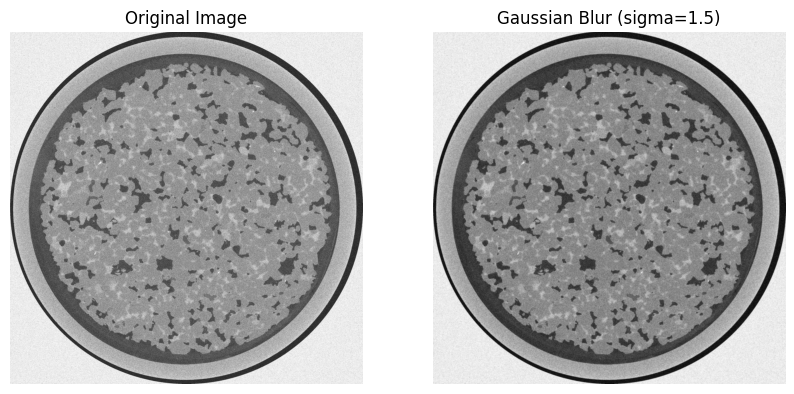

Blurred image saved at: D:\CAPSTONE\Results Backup\HQ_evalImgs\poisson_noisy_then_blur_image.png


In [8]:
#
#    Gaussian Blur
#
import numpy as np
import imageio.v3 as iio
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter

def apply_gaussian_blur(image, sigma=1):
    """
    Applies Gaussian blur to an image.
    :param image: Input grayscale image (NumPy array)
    :param sigma: Standard deviation for Gaussian kernel
    :return: Blurred image (NumPy array)
    """
    blurred_image = gaussian_filter(image, sigma=sigma)  # Apply Gaussian blur
    return np.clip(blurred_image, 0, 255).astype(np.uint8)  # Clip and convert to uint8

# Load the original uploaded image
image_path = "D:\\CAPSTONE\\Results Backup\\HQ_evalImgs\\noisy_0.102.png"  # Use the original uploaded file
original_image = iio.imread(image_path, mode='L')  # Load as grayscale

# Define Gaussian blur parameter
sigma = 1.5  # Standard deviation for Gaussian blur (adjustable)

# Apply Gaussian blur
blurred_image = apply_gaussian_blur(original_image, sigma)

# Save and display the blurred image
output_path = "D:\\CAPSTONE\\Results Backup\\HQ_evalImgs\\poisson_noisy_then_blur_image.png"
# iio.imwrite(output_path, blurred_image)

# print(original_image.dtype)

# Show original and blurred images side by side
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.imshow(original_image, cmap='gray')
plt.title("Original Image")
plt.axis("off")

plt.subplot(1,2,2)
plt.imshow(blurred_image, cmap='gray')
plt.title(f"Gaussian Blur (sigma={sigma})")
plt.axis("off")
plt.show()

print(f"Blurred image saved at: {output_path}")


## PyTorch Sandbox

In [ ]:
import sys
import os
import math
import pickle
import numpy as np
import copy
import time
from tqdm import tqdm
import matplotlib.pyplot as plt
from pathlib import Path
from PIL import Image

import torch
from torch.utils.data import Dataset, DataLoader
from torchvision.utils import save_image
from torchvision.transforms.functional import gaussian_blur
from torchvision.transforms import ToTensor

In [ ]:
def compute_spectral(image, ifft=False, magnitude=False, normalize=True):
        fft_shift = None
        if ifft:
            fft_shift = torch.fft.ifftshift(image, dim=(-2, -1))  # Shift zero frequency to center
        else:
            fft_image = torch.fft.fft2(image)  # Apply 2D Fourier Transform
            fft_shift = torch.fft.fftshift(fft_image, dim=(-2, -1))  # Shift zero frequency to center
        
        if magnitude:
            magnitude_spectrum = torch.abs(fft_shift)  # Get magnitude
            # Normalize the spectrum for consistency
            magnitude_spectrum = torch.log1p(magnitude_spectrum)  # Log scaling
            
            if normalize:
                magnitude_spectrum = (magnitude_spectrum - magnitude_spectrum.min()) / (magnitude_spectrum.max() - magnitude_spectrum.min())
                # magnitude_spectrum /= magnitude_spectrum.max()  # Normalize [0,1]
                
            return fft_shift.to(torch.complex64), magnitude_spectrum
        else: 
            return fft_shift.to(torch.complex64)
    
def apply_poisson(imgs, criterion=0.1, corruption_strength=0.102, device="cpu"):
    _, H, W = imgs.shape
    mask = (torch.rand((H, W), device=device) < criterion).float()
    
    poisson_noise = torch.poisson(torch.abs(imgs) * corruption_strength) / corruption_strength
    batch_mask = mask.unsqueeze(0)
    new_imgs = torch.where(batch_mask.bool(), poisson_noise, imgs)
    # print(f"Value Range of output: [{torch.min(new_imgs)}, {torch.max(new_imgs)}]")
    return torch.clip(new_imgs, -0.5, 0.5)
    
def apply_gaussian(imgs, mean=0.0, std= 0.1, device="cpu"):
    mask = torch.normal(mean=mean, std=std, size=imgs[0].shape, device=device)
    # print(f"Mask Shape: {mask.shape}")
    new_imgs = imgs + mask
    return torch.clip(new_imgs, -0.5, 0.5)

def apply_blur(imgs, kernel_size=3, sigma=1):
    # imgs.unsqueeze(1)
    return torch.clip(gaussian_blur(img=imgs, kernel_size=kernel_size, sigma=sigma), -0.5, 0.5)
    
def apply_bernoulli(imgs, p_edge=0.025, device="cpu"):
    _, H, W = imgs.shape
    y = torch.arange(H, dtype=torch.float32, device=device) - H // 2
    x = torch.arange(W, dtype=torch.float32, device=device) - W // 2
    yy, xx = torch.meshgrid(y**2, x**2, indexing='ij')
    r_dist = torch.sqrt(xx + yy)
    prob_mask = (p_edge ** (2.0 / W)) ** r_dist
    
    keep = (torch.rand(size=(H, W), device=device, dtype=torch.float32) ** 2) < prob_mask
    keep = keep & torch.flip(keep, dims=[0, 1])
    # Apply Mask
    mskd_specs = specs * keep
    spec_msk = keep.to(torch.float32)
    new_specs = compute_spectral(mskd_specs / torch.where(keep, prob_mask, 1e-8), ifft=True)
    new_imgs = torch.fft.ifft2(new_specs).real.float()
    return torch.clip(new_imgs, -0.5, 0.5), new_specs, spec_msk

In [ ]:
# import matplotlib.pyplot as plt
ds_dir = Path("PyTorchDatasets")
poisson_criterion = 0.1
poisson_strength = 0.0002

gaussian_mean = 0.0
gaussian_std = 0.1

blur_sigma = 1.0
blur_kernel = 15

bernoulli_probability_at_edge = 0.025

# (kernel = 17, sigm = 1.99, standdiv= 0.06, loss = 0.0126)
# (kernel = 15, sigm = 1.98, standdiv= 0.01, crit=0.1, strength=0.0002)


# Load Dataset
img_dataset = torch.load(ds_dir / "HQ_train_full_img.pth", weights_only=False)
loader = DataLoader(img_dataset, batch_size=2, shuffle=False)

img_size = (10,10)
img_size = (15,15)
batch_size = loader.batch_size
n_col = 2
n_row = math.ceil(batch_size/n_col)

plt.figure(figsize=(n_col * img_size[0], n_row * img_size[1])) # fig_size=(W, H)
# Read image from dataset
for idx, batch in tqdm(enumerate(loader), total=len(loader), desc="Processed Images"):
    imgs, specs = batch
    # print(imgs.shape)
    
    imgs = apply_gaussian(imgs, gaussian_mean, gaussian_std)
    imgs = apply_blur(imgs, kernel_size=blur_kernel, sigma=blur_sigma)
    imgs = apply_poisson(imgs, criterion=poisson_criterion, corruption_strength=poisson_strength)
    # imgs, _, _ = apply_bernoulli(imgs, p_edge=bernoulli_probability_at_edge) 
    
    imgs = imgs.add(0.5).mul(255).to(torch.uint8).to("cpu")
    plt.figure(figsize=(n_col * img_size[0], n_row * img_size[1])) # fig_size=(W, H)
    for idx2, img in enumerate(imgs):
        plt.subplot(n_row, n_col, idx2+1)
        plt.imshow(img.numpy(), cmap='gray')
        plt.title(f"Image-{idx2+1}")
        plt.axis("off")
    plt.show()
    
    time.sleep(1)
    if idx == 10:
        break

# batch = next(iter(loader))
# imgs, specs = batch
# imgs = imgs[:, 1000:-1000, 1000:-1000]
# best_params = (15, 0.98, 0.01,0.1, 0.0002)
# best_score = 0.012798348441720009 # float("inf")
# # kernels = [x for x in range(1, 24, 2)]
# sigmas = [round(x, 2) for x in np.arange(0.40, 2.0, 0.02)]
# stds = [round(x, 2) for x in np.arange(0.01, 0.15, 0.01)]
# kernels = [15, 17]
# # sigmas = [1.9, 1.99]
# # stds = [0.19, 1.99]
# poisson_crits = [round(x, 2) for x in np.arange(0.1, 0.2, 0.01)]
# poisson_strs = [round(x, 6) for x in np.arange(0.0001, 0.0005, 0.0001)]

# LQ_img = ToTensor()(Image.open(Path("Datasets/Mphase_3/Images/00000000.png")).convert("L"))[:, 1010:-1010, 1010:-1010] - 0.5
# print(imgs.shape, LQ_img.shape)
# assert imgs.shape == LQ_img.shape

# idx = 0
# for k in tqdm(kernels, position=0, leave=True, desc=f"Kernels", ncols=100):
#     for s in tqdm(sigmas, position=1, leave=True, desc=f"Sigmas", ncols=100):
#         for std in tqdm(stds, desc=f"STDs", leave=False, position=2, ncols=100):
#             for crit in poisson_crits: 
#                 for strength in poisson_strs:
#                     idx += 1
#                     img = apply_gaussian(imgs, mean=0.0, std=std)
#                     blu = apply_blur(img, kernel_size=k, sigma=s)
#                     output = apply_poisson(blu, criterion=crit, corruption_strength=strength)
                    
#                     score = torch.mean((output - LQ_img)**2)
#                     if score < best_score:
#                         best_score = score
#                         best_params = (k, s, std, crit, strength)
#                         print(f"New Loss:{best_score} | Kernel size: {k} | Sigma: {s} | Gaussian STD: {std} | Criterion: {crit} | Strength: {strength}")
            
# print(f"FINAL:\nMinimum Loss:{best_score} | Kernel size: {best_params[0]} | Sigma: {best_params[1]} | Gaussian STD: {best_params[2]} | Criterion: {best_params[3]} | Strength {best_params[4]}")

In [ ]:
best_params, best_score

In [ ]:
best_params, best_score

# Depricated Code

In [ ]:
# This is Depricated way to create dataset. Now dataset does not include any transformations or injected noise.

# Dataset Paths
dataset_dir = Path("noise2noise/datasets/")
train_dataset_path = dataset_dir / "HQ_20_xray_train.pkl"
valid_dataset_path = dataset_dir / "HQ_5_xray_valid.pkl"
eval_dataset_path = dataset_dir / "LQ_10_xray_eval.pkl"

# Data loader
class CustomDataset(Dataset):
    def __init__(self, inputs, targets, input_spectrals, input_spectral_masks, originals):
        self.inputs = inputs
        self.targets = targets
        self.input_spectrals = input_spectrals
        self.input_spectral_masks = input_spectral_masks
        self.originals = originals
        # assert self.inputs.shape == self.targets.shape and self.inputs.shape == self.input_spectrals.shape
        print("Dataset Information:")
        print(f"\t{inputs.shape[0]} samples in the dataset")
        print(f"\tSample size is {inputs.shape[1]} x {inputs.shape[2]}")
        print(f"\tSpectrum size is {input_spectrals.shape[1]} x {input_spectrals.shape[2]}")
        
    def __len__(self):
        return len(self.inputs)
        
    def __getitem__(self, idx):
        return self.inputs[idx], self.targets[idx], self.input_spectrals[idx], self.input_spectral_masks[idx], self.originals[idx]

def create_dataset(dataset_pkl_path, augment_params=dict(), add_noise=False, noisy_targets=False, **kwargs):
    # Read the Images from pkl files.
    dataset_pkl_path = Path(dataset_pkl_path)
    images, spectrals = None, None
    try:
        with open(dataset_pkl_path, "rb") as file:
            # Get Images and Spectrals from them.
            images, spectrals = pickle.load(file)
            spectrals = spectrals.astype(np.complex64)
            images = images.astype(np.float32) / 255.0 - 0.5
    except FileNotFoundError:
        print(f"Error: The file {dataset_pkl_path} was not found.")
    except Exception as e:
        print(f"Exception Raised: {e}")

    f_inputs, f_targets, f_input_spectrals, f_input_spectral_masks = [], [], [], []
    for img, spec in tqdm(zip(images, spectrals), total=len(images), desc=kwargs["dataset_desc"]):
        # Perform Augmentation
        augmented_image, augmented_spectral = augment_data(img, spec, augment_params)
        
        # Insert Noise in Input image
        if add_noise:
            corrupted_image, corrupted_spectral, corruption_mask = corrupt_data(augmented_image, augmented_spectral, corruption_type=kwargs["corruption_type"], corruption_params=kwargs["corruption_params"])
        else:
            corrupted_image, corrupted_spectral, corruption_mask = augmented_image, augmented_spectral, []
        # Noisy Target vs Clean Targets
        if noisy_targets:
            mod_corruption_params = copy.deepcopy(kwargs["corruption_params"])
            noise_factor = 1.0
            if kwargs["corruption_type"] == "bspec":
                mod_corruption_params["p_edge"] *= noise_factor
            elif kwargs["corruption_type"] == "poisson":
                mod_corruption_params["poisson_strength"] *= noise_factor
                
            target, _, _ = corrupt_data(augmented_image, augmented_spectral, corruption_type=kwargs["corruption_type"], corruption_params=mod_corruption_params)
            f_targets.append(target)
        else:
            f_targets.append(augmented_image)

        f_inputs.append(corrupted_image)
        f_input_spectrals.append(corrupted_spectral.astype(np.complex64))
        f_input_spectral_masks.append(corruption_mask)
    # Create training dataset.
    print(f"Component dtypes:\n \tInputs: {np.array(f_inputs).dtype} | Targets: {np.array(f_targets).dtype} | Input's Spectrals: {np.array(f_input_spectrals).dtype} | Spectral Masks: {np.array(f_input_spectral_masks).dtype} | Originals: {images.dtype}\n")
    return CustomDataset(np.array(f_inputs), np.array(f_targets), np.array(f_input_spectrals), np.array(f_input_spectral_masks), images)

# Create and save Dataset
ds_dir = Path("PyTorchDatasets")

train_dataset = create_dataset(dataset_pkl_path=valid_dataset_path, augment_params=dict(translate=32), add_noise=True, noisy_targets=True, dataset_desc='Training Dataset', corruption_type='bspec', corruption_params={"p_edge": 0.5, "distribution": "uniform", "poisson_strength": 0.102, "mask_ratio":0.1})
torch.save(train_dataset, ds_dir / "train_dataset_b.pth", pickle_protocol=4)

valid_dataset = create_dataset(dataset_pkl_path=valid_dataset_path, add_noise=True, noisy_targets=True, dataset_desc='Validation Dataset', corruption_type='bspec', corruption_params={"p_edge": 0.5, "distribution": "uniform", "poisson_strength": 0.102, "mask_ratio":0.1})
torch.save(valid_dataset, ds_dir / "valid_dataset_b.pth", pickle_protocol=4)

eval_dataset = create_dataset(dataset_pkl_path=eval_dataset_path, add_noise=True, noisy_targets=False, dataset_desc='Evaluation Dataset', corruption_type='bspec', corruption_params={"p_edge": 0.5, "distribution": "uniform", "poisson_strength": 0.102, "mask_ratio":0.1})
torch.save(eval_dataset, ds_dir / "eval_dataset_b_clean_targ.pth", pickle_protocol=4)

# Load Dataset
train_dataset = torch.load(ds_dir / "train_dataset_b.pth", weights_only=False)
valid_dataset = torch.load(ds_dir / "valid_dataset_b.pth", weights_only=False)
eval_dataset = torch.load(ds_dir / "eval_dataset_b_clean_targ.pth", weights_only=False)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=12, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=15, shuffle=False)
eval_loader = DataLoader(eval_dataset, batch_size=1, shuffle=False)

In [ ]:
# This was a version of the dataset that used the older pickle files from the TensorFlow code
class CTDataset(Dataset):
    def __init__(self, dataset_file, shuffle=False, n_images=None):
        """
        Args:
            dataset_file (str): Path to the .npz file containing images and spectral data.
        """
        # Can read imgs here and then apply corruptions later.
        data = np.load(dataset_file)
        self.images = torch.tensor(data["images"], dtype=torch.float32).unsqueeze(1)  # Add channel dim
        self.spectral_images = torch.tensor(data["spectral_images"], dtype=torch.float32).unsqueeze(1)
        assert self.images.shape == self.spectral_images.shape
        
        if shuffle:
            permutation = np.arange(self.images.shape[0])
            np.random.shuffle(permutation)
            if n_images is not None:
                permutation = permutation[:n_images]
            self.images = self.images[permutation]
            self.spectral_images = self.spectral_images[permutation]

        if n_images is not None:
            self.images = self.images[:n_images]
            self.spectral_images = self.spectral_images[:n_images]

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        return self.images[idx], self.spectral_images[idx]

# Newer version of minibatching code, more inline with the updated dataset
def _minibatchs(images, spectrals, shuffle: bool, corrupt_targets: bool, corruption_params=dict(), augment_params=dict(), n_images=None):
        assert images.shape == spectrals.shape

        total_samples = images.shape[0]
        total_indices = np.arange(total_samples)

        if shuffle:
            np.random.shuffle(total_indices)

        if n_images:
            total_indices = total_indicesp[:n_images]
            total_samples = len(total_indices)

        inputs, targets = [], []
        specs, spec_masks = [], []
        
        for idx in range(total_samples):
            img_aug, spec_aug = augment_data(images[idx], spectrals[idx], augment_params)
            img_corr, spec_corr, spec_mask_corr = corrupt_data(img_aug, spec_aug, corruption_params)
            inputs.append(img_corr)
            specs.append(spec_corr)
            spec_masks.append(spec_mask_corr)

            if corrupt_targets:
                mod_corruption_params = copy.deepcopy(corruption_params)
                
                if corruption_params["corruption_type"] == "bspec":
                    mod_corruption_params["p_edge"] *= 0.9
                elif corruption_params["corruption_type"] == "poisson":
                    mod_corruption_params["poisson_strength"] *= 0.9
                corr_targ, _, _ = corrupt_data(img_aug, spec_aug, mod_corruption_params)
                targets.append(corr_targ)
                
            else:
                targets.append(img_aug)

        yield total_indices, inputs, targets, spectral, spec_masks

# First version of minibatch (inspired by the TensorFlow version)
def _minibatchs(input_imgs, input_specs, shuffle: bool, corrupt_targets: bool, corruption_params=dict(), augment_params=dict(), n_images=None):
        assert input_imgs.shape == input_specs.shape

        total_samples = input_imgs.shape[0]
        total_indices = np.arange(total_samples)

        if shuffle:
            np.random.shuffle(total_indices)

        if n_images:
            total_indices = total_indicesp[:n_images]
            total_samples = len(total_indices)

        inputs, targets = [], []
        spectrals, spec_masks = [], []
        
        for idx in range(total_samples):
            img_aug, spec_aug = augment_data(input_imgs[idx], input_specs[idx], augment_params)
            img_corr, spec_corr, spec_mask_corr = corrupt_data(img_aug, spec_aug, corruption_params)
            inputs.append(img_corr)
            spectrals.append(spec_corr)
            spec_masks.append(spec_mask_corr)

            if corrupt_targets:
                mod_corruption_params = copy.deepcopy(corruption_params)
                
                if corruption_params["corruption_type"] == "bspec":
                    mod_corruption_params["p_edge"] *= 0.9
                elif corruption_params["corruption_type"] == "poisson":
                    mod_corruption_params["poisson_strength"] *= 0.9
                targ_corr, _, _ = corrupt_data(img_aug, spec_aug, mod_corruption_params)
                targets.append(targ_corr)
                
            else:
                targets.append(img_aug)

        yield total_indices, inputs, targets, spectral, spec_masks

In [ ]:
# Testing Block

# a, b, c, d, e = next(iter(valid_loader))
# print(a.shape, b.shape, c.shape, d.shape, e.shape)
# print(a.dtype, b.dtype, c.dtype, d.dtype, e.dtype)


# batch = next(iter(valid_loader))
# batch
# valid_spec_shape = next(iter(train_loader))[2].


# def _psnr_scores(image, target, max_pixel_value=255.0):
#     assert len(image.shape) == 2 and len(target.shape) == 2
#     image = (np.clip(image, -0.5, 0.5) + 0.5) * 255.0
#     target = (np.clip(target, -0.5, 0.5) + 0.5) * 255.0
    
#     # mse = self.loss_fn(image, target)      # Wondering if this would have worked.
#     mse = torch.mean((target - image)**2, dim=(0, 1))        
    
#     if mse == 0:
#         return float('inf')
    
#     psnr = 10.0 * torch.log10(max_pixel_value**2 / mse)
#     return psnr.item()

# print(_psnr_scores(torch.tensor(tr_inp), torch.tensor(va_orig)))

# valid_loader.batch_size


In [ ]:
# From Trainer class

def _eval(self, data_loader: DataLoader, output_dir: Path=Path(""), **kwargs):
    n_patches = 361
    patch_size = 255
    original_img_size = 2550
    overlap = 0.5
    
    if str(output_dir) =='.':
        output_dir = self.evaluation_test_path

    # Setup NIQE
    # niqe = NIQE(dst_pth=Path("./PyTorchDatasets"))
    # niqe.load()
    
    # Create blank image frame
    original_reconst = torch.zeros((1, original_img_size, original_img_size), dtype=torch.float32, device=self.device)
    denoised_reconst = torch.zeros((1, original_img_size, original_img_size), dtype=torch.float32, device=self.device)
    target_reconst = torch.zeros((1, original_img_size, original_img_size), dtype=torch.float32, device=self.device)
    input_reconst = torch.zeros((1, original_img_size, original_img_size), dtype=torch.float32, device=self.device)
    mod_count = torch.zeros((1, original_img_size, original_img_size), dtype=torch.float32, device=self.device)
    
    # Establish the step
    step = int(patch_size * (1-overlap))
    patches_per_row = (original_img_size - patch_size) // step + 1

    patch_idx = 0
    img_idx = 1
    
    # Model in eval state
    self.model.eval()
    
    # Inference mode
    with torch.inference_mode():
        psnr_file = output_dir / "PSNR.txt"
        with psnr_file.open('wt') as fout:
            fout.write(f'Sr.no.:\tOriginal\tInput\t\tOutput\t\tGains\t\tNIQE\n---------------------------------------------------------------------------------\n')
            # Iterate over the Eval dataset
            # fig, axes = plt.subplots(10,1, figsize=(20, 50))
            for idx, batch in tqdm(enumerate(data_loader), desc="Evaluation Dataset", total=len(data_loader), position=0, leave=True):
                # inp, targ, _, _, orig = batch
                # inp, targ, orig = inp.to(self.device), targ.to(self.device), orig.to(self.device)
                imgs, specs = batch
                imgs, specs = imgs.to(self.device), specs.to(self.device)
                inp, targ, _, _, orig = self._preprocessbatch(imgs, specs,
                                                             noisy_targets=False,
                                                             inject_noise=False,
                                                             **kwargs)
                # Predict
                denoised_op = self.model(inp)
                
                # Generate results and images
                r, c = (patch_idx // patches_per_row) * step, (patch_idx % patches_per_row) * step
                
                original_reconst[:, r : r+patch_size, c : c+patch_size] += orig
                denoised_reconst[:, r : r+patch_size, c : c+patch_size] += denoised_op
                target_reconst[:, r : r+patch_size, c : c+patch_size] += targ
                input_reconst[:, r : r+patch_size, c : c+patch_size] += inp
                mod_count[:, r : r+patch_size, c : c+patch_size] += 1
                patch_idx += 1
                
                if patch_idx == n_patches:
                    # New Image will start from next iteration

                    # Consolidate the reconstructions
                    mod_count[mod_count == 0] = 1
                    original_reconst /= mod_count
                    denoised_reconst /= mod_count
                    target_reconst /= mod_count
                    input_reconst /= mod_count
                    
                    # Create 4-in-1
                    prim = [x.squeeze(0) for x in [original_reconst, input_reconst, denoised_reconst, target_reconst]]
                    spec = [v for _, v in (self._compute_spectral(x, magnitude=True, normalize=False) for x in prim)]
                    pimg = torch.cat(prim, dim=1) + 0.5
                    simg = torch.cat(spec, dim=1) * 0.05
                    # img = torch.clip(torch.cat([pimg, simg], dim=0), 0.0, 1.0)
                    img = torch.cat([pimg, simg], dim=0)

                    # axes[img_idx-1][0].imshow(simg.detach().cpu().numpy(), cmap='gray', vmin=0, vmax=1)
                    # axes[img_idx-1][0].set_title(img_idx)
                    
                    # prim = [x.squeeze(0).detach().cpu().numpy() for x in [original_reconst, input_reconst, denoised_reconst, target_reconst]]
                    # spec = [v for _, v in (compute_spectral_image(x, magnitude=True) for x in prim)]
                    # pimg = np.concatenate(prim, axis=1) + 0.5
                    # simg = np.concatenate(spec, axis=1) * 0.03
                    # img = np.clip(np.concatenate([pimg, simg], axis=0), 0, 1)
                    
                    # Save the current reconstruction
                    save_image(img, output_dir / f"final{img_idx:03d}.png", normalize=False)
                    save_image((torch.clip(original_reconst, -0.5, 0.5) + 0.5).cpu(), output_dir / f"original{img_idx:03d}.png")
                    save_image((torch.clip(denoised_reconst, -0.5, 0.5) + 0.5).cpu(), output_dir / f"output{img_idx:03d}.png")
                    save_image((torch.clip(target_reconst, -0.5, 0.5) + 0.5).cpu(), output_dir / f"target{img_idx:03d}.png")
                    save_image((torch.clip(input_reconst, -0.5, 0.5) + 0.5).cpu(), output_dir / f"input{img_idx:03d}.png")
                    
                    # Calculate PSNR scores
                    psnr_orig_vs_targ = self._psnr_scores(original_reconst, target_reconst).item()
                    psnr_denoise_vs_targ = self._psnr_scores(denoised_reconst, target_reconst).item()
                    psnr_input_vs_targ = self._psnr_scores(input_reconst, target_reconst).item()
                    # niqe_score = niqe.score(torch.clip(denoised_reconst.squeeze(0), -0.5, 0.5).cpu().numpy())
                    niqe_score = float("inf")
                    fout.write(f'{img_idx:03d}:\t{psnr_orig_vs_targ:0.5f}\t\t{psnr_input_vs_targ:0.5f}\t\t{psnr_denoise_vs_targ:0.5f}\t\t{(psnr_denoise_vs_targ - psnr_orig_vs_targ):0.5f}\t\t{niqe_score}\n')
                    
                    # Flush the image frames
                    original_reconst *= 0.0
                    denoised_reconst *= 0.0
                    mod_count *= 0.0
                    
                    # reset indices
                    patch_idx = 0
                    img_idx += 1
    
def testing(self):
    batch = next(iter(self.train_loader))
    img, spec = batch
    print("Initial: ", img.shape, spec.shape)
    s = self._compute_spectral(img)
    print("Spectral computed", s.shape)
                         